<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [ ]:
#@title Install dependencies and downloading training data from github
# https://github.com/lifesboy/selks-lstm-data.git

!python -m pip install ray==1.13.0 "ray[tune]"==1.13.0 "ray[rllib]"==1.13.0 "ray[default]"==1.13.0 "ray[serve]"==1.13.0 > install.log
!rm -rf /cic && git clone https://github.com/lifesboy/selks-lstm-data.git /cic

#!unzip /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.2.1671267995.pcap_20221217T140054.csv.zip -d /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/
!rm -rf /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.2.1671267995.pcap_20221217T140054.csv.zip
!unzip /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.7.1671284923.pcap_20221217T140054.csv.zip -d /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/
!rm -rf /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.7.1671284923.pcap_20221217T140054.csv.zip

#!unzip /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/5cd99e3770df40b3bd196c04b1f3c425_000000_000000.csv.zip -d /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/
!rm -rf /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/5cd99e3770df40b3bd196c04b1f3c425_000000_000000.csv.zip
!unzip /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/79706a01510e492fbe631e0d8fc22c9d_000000_000000.csv.zip -d /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/
!rm -rf /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/79706a01510e492fbe631e0d8fc22c9d_000000_000000.csv.zip

Cloning into '/cic'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 224 (delta 12), reused 26 (delta 5), pack-reused 186
Receiving objects: 100% (224/224), 88.88 MiB | 16.43 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Archive:  /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.7.1671284923.pcap_20221217T140054.csv.zip
  inflating: /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.7.1671284923.pcap_20221217T140054.csv  
Archive:  /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/79706a01510e492fbe631e0d8fc22c9d_000000_000000.csv.zip
  inflating: /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/79706a01510e492fbe631e0d8fc22c9d_000000_000000.csv  


In [ ]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
#@title Version Info
!git --version
!python --version
!ray --version
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


git version 2.17.1
Python 3.8.16
ray, version 1.13.0
tf version:  2.9.2
tf.keras version: 2.9.0


In [ ]:
#@title Import Libraries
import ray
import pyarrow
import pyarrow as pa
import pandas as pd
from pandas import DataFrame
from pyarrow import csv

from ray import tune
from ray.data import Dataset
from ray.data.aggregate import Count
from ray.tune.logger import TBXLoggerCallback
from ray.tune.registry import register_env
from ray.tune.utils.log import Verbosity

from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

from sklearn import preprocessing

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

def show_scattered(x, label="data"):
  print(f"#{label}=", x.shape)
  A = np.matrix(x)
  #scatter plot x - column 0, y - column 1, shown with marker o
  plt.plot(A[:, 0], A[:, 1], 'o', label = label)
  plt.legend()
  plt.show()
 
def show_scattered_3d(x3d, title="data"):
  print(f"#{title}=", x3d.shape)
  
  if (len(x3d.shape) == 2):
    x3d = x3d.reshape(x3d.shape[0], x3d.shape[1], 1)

  # Creating dataset
  z,x,y = x3d.nonzero()
  #c = [x3d[z[i]][x[i]][y[i]] for i in range(0, len(z))]
  print("x=", x)
  print("y=", y)
  print("z=", z)
  #print("c=", c)
  
  # Creating figure
  fig = plt.figure(figsize = (10, 7))
  ax = plt.axes(projection ="3d")

  # Creating plot
  ax.scatter3D(x, y, z, color = "green")
  #img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
  #fig.colorbar(img)
  plt.title(title)
  
  # show plot
  plt.show()

def show_scattered_4d(x3d, title="data"):
  print(f"#{title}=", x3d.shape)
  
  if (len(x3d.shape) == 2):
    x3d = x3d.reshape(x3d.shape[0], x3d.shape[1], 1)

  # Creating dataset
  #z,x,y = x3d.nonzero()
  #c = np.array([x3d[z[i]][x[i]][y[i]] for i in range(0, len(z))])

  z = []
  x = []
  y = []
  c = []
  for i in range(0, x3d.shape[0]):
    for j in range(0, x3d.shape[1]):
      for k in range(0, x3d.shape[2]):
        z.append(i)
        x.append(j)
        y.append(k)
        c.append(x3d[i][j][k])

  z = np.array(z)
  x = np.array(x)
  y = np.array(y)
  c = np.array(c)

  print("x=", x)
  print("y=", y)
  print("z=", z)
  print("c=", c)
  
  # Creating figure
  fig = plt.figure(figsize = (10, 7))
  #plt.yticks(np.arange(min(y), max(y), 1))
  ax = plt.axes(projection ="3d")

  # Creating plot
  img = ax.scatter(x, y, z, c=c, cmap=plt.cm.get_cmap('hot_r'), vmin=0, vmax=1)
  fig.colorbar(img)
  plt.title(title)
  
  # show plot
  plt.show()

def show_train_metric(history, title="title"):
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title(title)
  plt.legend()

# 3.INPUT
Let's generate a sample input with time dimension as below:

In [ ]:
#@title Declare features vs input schema

FLOW_ID = 'flow_id'
SRC_IP = 'src_ip'
SRC_PORT = 'src_port'
SRC_MAC = 'src_mac'
DST_IP = 'dst_ip'
DST_PORT = 'dst_port'
DST_MAC = 'dst_mac'
PROTOCOL = 'protocol'
TIMESTAMP = 'timestamp'
FLOW_DURATION = 'flow_duration'
TOT_FWD_PKTS = 'tot_fwd_pkts'
TOT_BWD_PKTS = 'tot_bwd_pkts'

TOTLEN_FWD_PKTS = 'totlen_fwd_pkts'
TOTLEN_BWD_PKTS = 'totlen_bwd_pkts'
FWD_PKT_LEN_MAX = 'fwd_pkt_len_max'
FWD_PKT_LEN_MIN = 'fwd_pkt_len_min'
FWD_PKT_LEN_MEAN = 'fwd_pkt_len_mean'
FWD_PKT_LEN_STD = 'fwd_pkt_len_std'
BWD_PKT_LEN_MAX = 'bwd_pkt_len_max'
BWD_PKT_LEN_MIN = 'bwd_pkt_len_min'
BWD_PKT_LEN_MEAN = 'bwd_pkt_len_mean'
BWD_PKT_LEN_STD = 'bwd_pkt_len_std'
FLOW_BYTS_S = 'flow_byts_s'
FLOW_PKTS_S = 'flow_pkts_s'
FLOW_IAT_MEAN = 'flow_iat_mean'
FLOW_IAT_STD = 'flow_iat_std'
FLOW_IAT_MAX = 'flow_iat_max'
FLOW_IAT_MIN = 'flow_iat_min'
FWD_IAT_TOT = 'fwd_iat_tot'
FWD_IAT_MEAN = 'fwd_iat_mean'
FWD_IAT_STD = 'fwd_iat_std'
FWD_IAT_MAX = 'fwd_iat_max'
FWD_IAT_MIN = 'fwd_iat_min'
BWD_IAT_TOT = 'bwd_iat_tot'
BWD_IAT_MEAN = 'bwd_iat_mean'
BWD_IAT_STD = 'bwd_iat_std'
BWD_IAT_MAX = 'bwd_iat_max'
BWD_IAT_MIN = 'bwd_iat_min'
FWD_PSH_FLAGS = 'fwd_psh_flags'
BWD_PSH_FLAGS = 'bwd_psh_flags'
FWD_URG_FLAGS = 'fwd_urg_flags'
BWD_URG_FLAGS = 'bwd_urg_flags'
FWD_HEADER_LEN = 'fwd_header_len'
BWD_HEADER_LEN = 'bwd_header_len'
FWD_PKTS_S = 'fwd_pkts_s'
BWD_PKTS_S = 'bwd_pkts_s'
PKT_LEN_MIN = 'pkt_len_min'
PKT_LEN_MAX = 'pkt_len_max'
PKT_LEN_MEAN = 'pkt_len_mean'
PKT_LEN_STD = 'pkt_len_std'
PKT_LEN_VAR = 'pkt_len_var'
FIN_FLAG_CNT = 'fin_flag_cnt'
SYN_FLAG_CNT = 'syn_flag_cnt'
RST_FLAG_CNT = 'rst_flag_cnt'
PSH_FLAG_CNT = 'psh_flag_cnt'
ACK_FLAG_CNT = 'ack_flag_cnt'
URG_FLAG_CNT = 'urg_flag_cnt'
CWE_FLAG_COUNT = 'cwe_flag_count'
ECE_FLAG_CNT = 'ece_flag_cnt'
DOWN_UP_RATIO = 'down_up_ratio'
PKT_SIZE_AVG = 'pkt_size_avg'
FWD_SEG_SIZE_AVG = 'fwd_seg_size_avg'
BWD_SEG_SIZE_AVG = 'bwd_seg_size_avg'
FWD_BYTS_B_AVG = 'fwd_byts_b_avg'
FWD_PKTS_B_AVG = 'fwd_pkts_b_avg'
FWD_BLK_RATE_AVG = 'fwd_blk_rate_avg'
BWD_BYTS_B_AVG = 'bwd_byts_b_avg'
BWD_PKTS_B_AVG = 'bwd_pkts_b_avg'
BWD_BLK_RATE_AVG = 'bwd_blk_rate_avg'
SUBFLOW_FWD_PKTS = 'subflow_fwd_pkts'
SUBFLOW_FWD_BYTS = 'subflow_fwd_byts'
SUBFLOW_BWD_PKTS = 'subflow_bwd_pkts'
SUBFLOW_BWD_BYTS = 'subflow_bwd_byts'
INIT_FWD_WIN_BYTS = 'init_fwd_win_byts'
INIT_BWD_WIN_BYTS = 'init_bwd_win_byts'
FWD_ACT_DATA_PKTS = 'fwd_act_data_pkts'
FWD_SEG_SIZE_MIN = 'fwd_seg_size_min'
ACTIVE_MEAN = 'active_mean'
ACTIVE_STD = 'active_std'
ACTIVE_MAX = 'active_max'
ACTIVE_MIN = 'active_min'
IDLE_MEAN = 'idle_mean'
IDLE_STD = 'idle_std'
IDLE_MAX = 'idle_max'
IDLE_MIN = 'idle_min'
LABEL = 'label'

ALL_FEATURES = [
    #SRC_IP,
    #SRC_PORT,
    #SRC_MAC,
    #DST_IP,
    #DST_PORT,
    #DST_MAC,
    PROTOCOL,
    #TIMESTAMP,
    FLOW_DURATION,
    TOT_FWD_PKTS,
    TOT_BWD_PKTS,

    TOTLEN_FWD_PKTS,
    TOTLEN_BWD_PKTS,
    FWD_PKT_LEN_MAX,
    FWD_PKT_LEN_MIN,
    FWD_PKT_LEN_MEAN,
    FWD_PKT_LEN_STD,
    BWD_PKT_LEN_MAX,
    BWD_PKT_LEN_MIN,
    BWD_PKT_LEN_MEAN,
    BWD_PKT_LEN_STD,
    FLOW_BYTS_S,
    FLOW_PKTS_S,
    FLOW_IAT_MEAN,
    FLOW_IAT_STD,
    FLOW_IAT_MAX,
    FLOW_IAT_MIN,
    FWD_IAT_TOT,
    FWD_IAT_MEAN,
    FWD_IAT_STD,
    FWD_IAT_MAX,
    FWD_IAT_MIN,
    BWD_IAT_TOT,
    BWD_IAT_MEAN,
    BWD_IAT_STD,
    BWD_IAT_MAX,
    BWD_IAT_MIN,
    FWD_PSH_FLAGS,
    BWD_PSH_FLAGS,
    FWD_URG_FLAGS,
    BWD_URG_FLAGS,
    FWD_HEADER_LEN,
    BWD_HEADER_LEN,
    FWD_PKTS_S,
    BWD_PKTS_S,
    PKT_LEN_MIN,
    PKT_LEN_MAX,
    PKT_LEN_MEAN,
    PKT_LEN_STD,
    PKT_LEN_VAR,
    FIN_FLAG_CNT,
    SYN_FLAG_CNT,
    RST_FLAG_CNT,
    PSH_FLAG_CNT,
    ACK_FLAG_CNT,
    URG_FLAG_CNT,
    CWE_FLAG_COUNT,
    ECE_FLAG_CNT,
    DOWN_UP_RATIO,
    PKT_SIZE_AVG,
    FWD_SEG_SIZE_AVG,
    BWD_SEG_SIZE_AVG,
    FWD_BYTS_B_AVG,
    FWD_PKTS_B_AVG,
    FWD_BLK_RATE_AVG,
    BWD_BYTS_B_AVG,
    BWD_PKTS_B_AVG,
    BWD_BLK_RATE_AVG,
    SUBFLOW_FWD_PKTS,
    SUBFLOW_FWD_BYTS,
    SUBFLOW_BWD_PKTS,
    SUBFLOW_BWD_BYTS,
    INIT_FWD_WIN_BYTS,
    INIT_BWD_WIN_BYTS,
    FWD_ACT_DATA_PKTS,
    FWD_SEG_SIZE_MIN,
    ACTIVE_MEAN,
    ACTIVE_STD,
    ACTIVE_MAX,
    ACTIVE_MIN,
    IDLE_MEAN,
    IDLE_STD,
    IDLE_MAX,
    IDLE_MIN,
]

ALL_FEATURES_SCHEMA = {
  FLOW_ID: pa.string(),
  SRC_IP: pa.string(),
  SRC_PORT: pa.float64(),
  SRC_MAC: pa.string(),
  DST_IP: pa.string(),
  DST_PORT: pa.float64(),
  DST_MAC: pa.string(),
  PROTOCOL: pa.float64(),
  TIMESTAMP: pa.string(),
  FLOW_DURATION: pa.float64(),
  TOT_FWD_PKTS: pa.float64(),
  TOT_BWD_PKTS: pa.float64(),
  TOTLEN_FWD_PKTS: pa.float64(),
  TOTLEN_BWD_PKTS: pa.float64(),
  FWD_PKT_LEN_MAX: pa.float64(),
  FWD_PKT_LEN_MIN: pa.float64(),
  FWD_PKT_LEN_MEAN: pa.float64(),
  FWD_PKT_LEN_STD: pa.float64(),
  BWD_PKT_LEN_MAX: pa.float64(),
  BWD_PKT_LEN_MIN: pa.float64(),
  BWD_PKT_LEN_MEAN: pa.float64(),
  BWD_PKT_LEN_STD: pa.float64(),
  FLOW_BYTS_S: pa.float64(),
  FLOW_PKTS_S: pa.float64(),
  FLOW_IAT_MEAN: pa.float64(),
  FLOW_IAT_STD: pa.float64(),
  FLOW_IAT_MAX: pa.float64(),
  FLOW_IAT_MIN: pa.float64(),
  FWD_IAT_TOT: pa.float64(),
  FWD_IAT_MEAN: pa.float64(),
  FWD_IAT_STD: pa.float64(),
  FWD_IAT_MAX: pa.float64(),
  FWD_IAT_MIN: pa.float64(),
  BWD_IAT_TOT: pa.float64(),
  BWD_IAT_MEAN: pa.float64(),
  BWD_IAT_STD: pa.float64(),
  BWD_IAT_MAX: pa.float64(),
  BWD_IAT_MIN: pa.float64(),
  FWD_PSH_FLAGS: pa.float64(),
  BWD_PSH_FLAGS: pa.float64(),
  FWD_URG_FLAGS: pa.float64(),
  BWD_URG_FLAGS: pa.float64(),
  FWD_HEADER_LEN: pa.float64(),
  BWD_HEADER_LEN: pa.float64(),
  FWD_PKTS_S: pa.float64(),
  BWD_PKTS_S: pa.float64(),
  PKT_LEN_MIN: pa.float64(),
  PKT_LEN_MAX: pa.float64(),
  PKT_LEN_MEAN: pa.float64(),
  PKT_LEN_STD: pa.float64(),
  PKT_LEN_VAR: pa.float64(),
  FIN_FLAG_CNT: pa.float64(),
  SYN_FLAG_CNT: pa.float64(),
  RST_FLAG_CNT: pa.float64(),
  PSH_FLAG_CNT: pa.float64(),
  ACK_FLAG_CNT: pa.float64(),
  URG_FLAG_CNT: pa.float64(),
  CWE_FLAG_COUNT: pa.float64(),
  ECE_FLAG_CNT: pa.float64(),
  DOWN_UP_RATIO: pa.float64(),
  PKT_SIZE_AVG: pa.float64(),
  FWD_SEG_SIZE_AVG: pa.float64(),
  BWD_SEG_SIZE_AVG: pa.float64(),
  FWD_BYTS_B_AVG: pa.float64(),
  FWD_PKTS_B_AVG: pa.float64(),
  FWD_BLK_RATE_AVG: pa.float64(),
  BWD_BYTS_B_AVG: pa.float64(),
  BWD_PKTS_B_AVG: pa.float64(),
  BWD_BLK_RATE_AVG: pa.float64(),
  SUBFLOW_FWD_PKTS: pa.float64(),
  SUBFLOW_FWD_BYTS: pa.float64(),
  SUBFLOW_BWD_PKTS: pa.float64(),
  SUBFLOW_BWD_BYTS: pa.float64(),
  INIT_FWD_WIN_BYTS: pa.float64(),
  INIT_BWD_WIN_BYTS: pa.float64(),
  FWD_ACT_DATA_PKTS: pa.float64(),
  FWD_SEG_SIZE_MIN: pa.float64(),
  ACTIVE_MEAN: pa.float64(),
  ACTIVE_STD: pa.float64(),
  ACTIVE_MAX: pa.float64(),
  ACTIVE_MIN: pa.float64(),
  IDLE_MEAN: pa.float64(),
  IDLE_STD: pa.float64(),
  IDLE_MAX: pa.float64(),
  IDLE_MIN: pa.float64(),
  
  LABEL: pa.float64(),
  #LABEL: pa.string(),
}

ALL_FEATURES_SCHEMA_LABEL_STRING = {
   **ALL_FEATURES_SCHEMA,
    LABEL: pa.string()
}

#---------------------------------
class CicCSVDatasource(ray.data.datasource.CSVDatasource):

    def _read_stream(self, f: 'pyarrow.NativeFile', path: str, **reader_args):
        read_options = reader_args.pop('read_options', csv.ReadOptions(use_threads=False))
        parse_options = reader_args.pop('parse_options', csv.ParseOptions())
        # Re-init invalid row handler: https://issues.apache.org/jira/browse/ARROW-17641
        if hasattr(parse_options, 'invalid_row_handler'):
            parse_options.invalid_row_handler = parse_options.invalid_row_handler

        reader = csv.open_csv(f, read_options=read_options, parse_options=parse_options, **reader_args)
        schema = None
        while True:
            try:
                batch = reader.read_next_batch()
                table = pyarrow.Table.from_batches([batch], schema=schema)
                if schema is None:
                    schema = table.schema
                yield table
            except StopIteration:
                return

convert_options = csv.ConvertOptions(column_types=ALL_FEATURES_SCHEMA)
convert_options_label_string = csv.ConvertOptions(column_types=ALL_FEATURES_SCHEMA_LABEL_STRING)
parse_options = csv.ParseOptions(delimiter=",", invalid_row_handler=lambda x: 'skip')
def read_csv_in_dir(dir: str) -> Dataset:
  dataset: Dataset = ray.data.read_datasource(
      CicCSVDatasource(),
      paths=[dir],
      parse_options=parse_options,
      convert_options=convert_options)
  return dataset.fully_executed().repartition(num_blocks=1)

def read_csv_in_dir_label_string(dir: str) -> Dataset:
  dataset: Dataset = ray.data.read_datasource(
      CicCSVDatasource(),
      paths=[dir],
      parse_options=parse_options,
      convert_options=convert_options_label_string)
  return dataset.fully_executed().repartition(num_blocks=1)

In [ ]:
#@title Generate an input sequence
cell_size = 32 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 256 #@param {type:"integer"}
n_timesteps_in = 30  #@param {type:"integer"}
#each input sample has 4 values

n_features = 50   #@param {type:"integer"}
#each value is one_hot_encoded with 10 0/1
#n_timesteps_out = 2  #@param {type:"integer"}
#each output sample has 2 values padded with 0

# generate datasets
train_size= 500 #@param {type:"integer"}
test_size = 5  #@param {type:"integer"}
predict_size = 5  #@param {type:"integer"}

(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=n_features)

X_train = keras.preprocessing.sequence.pad_sequences(X_train[0:train_size * n_timesteps_in], maxlen=n_features)
y_train = y_train[0:train_size * n_timesteps_in]
X_test = keras.preprocessing.sequence.pad_sequences(X_test[0:test_size * n_timesteps_in], maxlen=n_features)
y_test = y_test[0:test_size * n_timesteps_in]

X_train = array([X_train]).reshape((train_size, n_timesteps_in, n_features))
y_train = array([y_train]).reshape((train_size, n_timesteps_in))

X_test = array([X_test]).reshape((test_size, n_timesteps_in, n_features))
y_test = array([y_test]).reshape((test_size, n_timesteps_in))


features_request = ",".join(ALL_FEATURES[0:n_features])
print("features_request=", features_request)


C_fsource = '/cic/dataset/feature_extracted/cic2018/' #@param {type:"string"}
C_source = '/cic/dataset/nomalized_labeled/cic2018_ftp_bruteforce/' #@param {type:"string"}
C_fdata: Dataset = read_csv_in_dir_label_string(C_fsource)
C_data: Dataset = read_csv_in_dir(C_source)
C_fcount: DataFrame = C_fdata.groupby(LABEL).aggregate(Count()).to_pandas()
C_count: DataFrame = C_data.groupby(LABEL).aggregate(Count()).to_pandas()

L_fsource = '/cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/' #@param {type:"string"}
L_source = '/cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/' #@param {type:"string"}
L_fdata: Dataset = read_csv_in_dir_label_string(L_fsource)
L_data: Dataset = read_csv_in_dir(L_source)
L_fcount: DataFrame = L_fdata.groupby(LABEL).aggregate(Count()).to_pandas()
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = sorted(list(set(features_request.split(",")).intersection(C_data.schema(fetch_if_missing=True).names)))
print (features)

C_train = DataFrame.from_records(C_data.take(train_size * n_timesteps_in))
CX_train = C_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Cy_train = C_train[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

C_test = DataFrame.from_records(C_data.take(test_size * n_timesteps_in))
CX_test = C_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Cy_test = C_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)


L_ftrain = DataFrame.from_records(L_fdata.take(predict_size * n_timesteps_in))
L_ftrain[LABEL] = L_ftrain.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)

L_ftest = DataFrame.from_records(L_fdata.take(test_size * n_timesteps_in))
L_ftest[LABEL] = L_ftest.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in))
L_train[LABEL] = L_ftrain[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in))
L_test[LABEL] = L_ftest[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

#========
print ('X_train=', X_train.shape)
print ('y_train=', y_train.shape)
print (DataFrame(y_train.reshape(-1)).describe())

print ('X_test=', X_test.shape)
print ('y_test=', y_test.shape)
print (DataFrame(y_test.reshape(-1)).describe())

#========
print ('CX_train=', CX_train.shape)
print ('Cy_train=', Cy_train.shape)
print (DataFrame(Cy_train.reshape(-1)).describe())

print ('CX_test=', CX_test.shape)
print ('Cy_test=', Cy_test.shape)
print (DataFrame(Cy_test.reshape(-1)).describe())

#========
print ('LX_train=', LX_train.shape)
print ('Ly_train=', Ly_train.shape)
print (DataFrame(Ly_train.reshape(-1)).describe())

print ('LX_test=', LX_test.shape)
print ('Ly_test=', Ly_test.shape)
print (DataFrame(Ly_test.reshape(-1)).describe())

features_request= protocol,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,bwd_pkt_len_max,bwd_pkt_len_min,bwd_pkt_len_mean,bwd_pkt_len_std,flow_byts_s,flow_pkts_s,flow_iat_mean,flow_iat_std,flow_iat_max,flow_iat_min,fwd_iat_tot,fwd_iat_mean,fwd_iat_std,fwd_iat_max,fwd_iat_min,bwd_iat_tot,bwd_iat_mean,bwd_iat_std,bwd_iat_max,bwd_iat_min,fwd_psh_flags,bwd_psh_flags,fwd_urg_flags,bwd_urg_flags,fwd_header_len,bwd_header_len,fwd_pkts_s,bwd_pkts_s,pkt_len_min,pkt_len_max,pkt_len_mean,pkt_len_std,pkt_len_var,fin_flag_cnt,syn_flag_cnt,rst_flag_cnt,psh_flag_cnt,ack_flag_cnt,urg_flag_cnt,cwe_flag_count


Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 62.35it/s]


['ack_flag_cnt', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_urg_flags', 'cwe_flag_count', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_urg_flags', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
X_train= (500, 30, 50)
y_train= (500, 30)
                  0
count  15000.000000
mean       0.502200
std        0.500012
min        0.000000
25%        0.000000
50%        1.00

# 4.INTRODUCTION

In this tutorial, we will focus on the outputs of LSTM layer in Keras. 

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.

To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

Therefore, in this tutorial, we will learn and use 3 important parameters (units, return_sequences, and return_state).

At the end of the tutorial you will be able to manage LSTM layer to satisfy the model requirements correctly.

If you are interested in LSTM or Deep Learning with Keras, please subsribe to my channel and activate the notifications so that you can be notified when new content is online. Thank you!

Before start, I would like to mention that I already prepared several content for having a better understanding of LSTM. You can access these videos by following playlists below:
  * All About LSTM
  * Seq2Seq Learning Problem
  * Applied Machine Learning with Keras

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

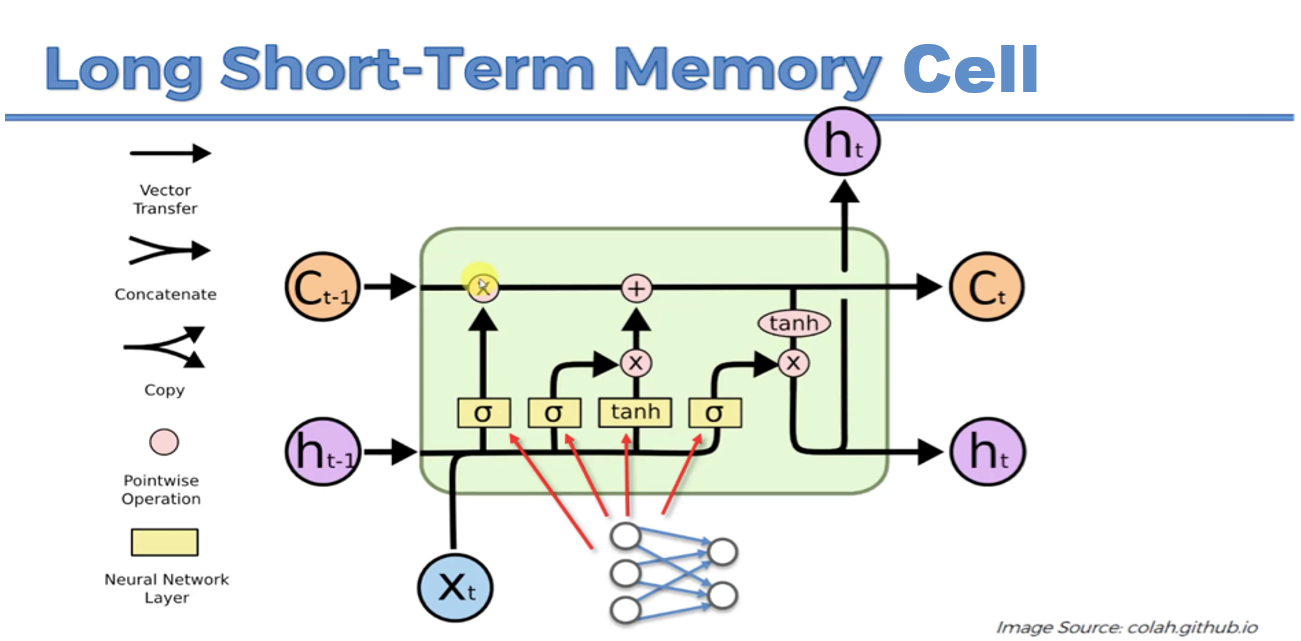

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

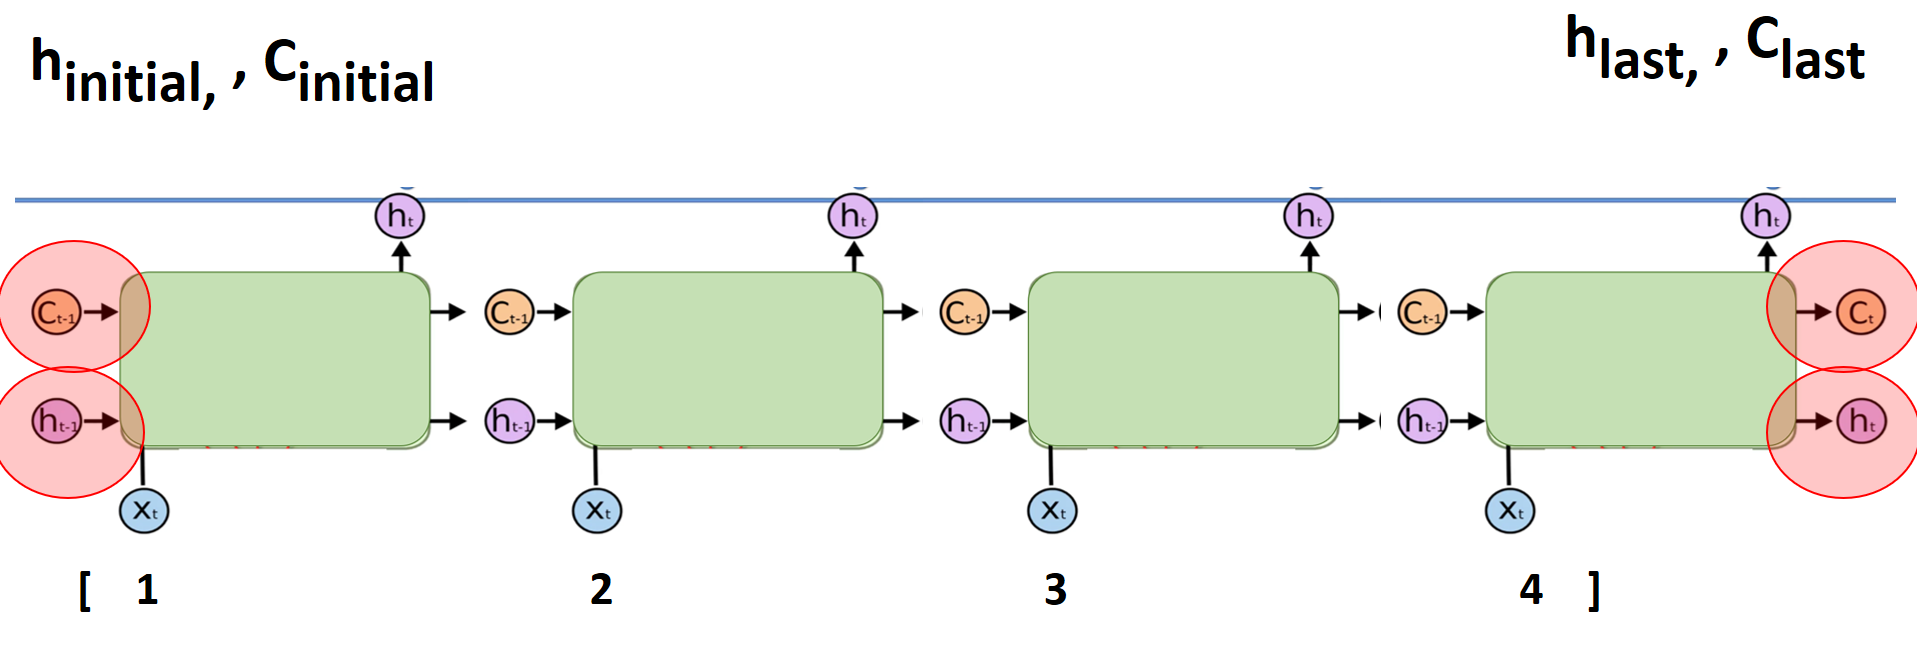

## 4.2.LSTM OUTPUTS
LSTM can return 4 different sets of results/states according to the given parameters:


1.   **Default:** Last Hidden State  (Hidden State of the last time step)
2.   **return_sequences=True :** All Hidden States (Hidden State of ALL the time steps)
3.   **return_state=True     :** Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
4. **return_sequences=True + return_state=True:** All Hidden States (Hidden State of ALL the time steps) + Last Hidden State + Last Cell State (Cell State of the last time step)

Using these 4 different results/states we can stack  LSTM layers in various ways



### 4.2.1.LSTM Default return value:
Output is only the **hidden state** at the  ***last time step***.

Because *return_sequences* and *return_states* parameters are default (**False**). 

The size of output is **2D** array of real numbers. 

The **first dimension** is indicating the ***number of samples in the batch*** given to the LSTM layer

The **second dimension** is the **dimensionality of the output space**  defined by the **units** parameter in Keras LSTM implementation. 

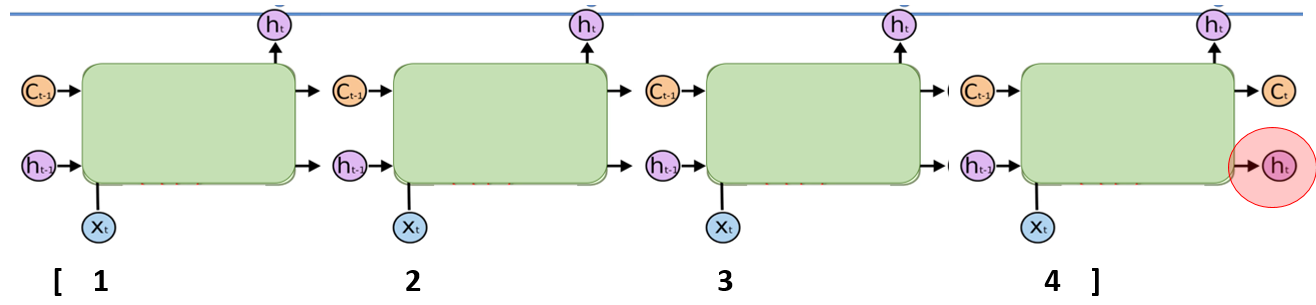

**Example Code:**
Since, in the following examples, the **LSTM unit parameter (dimensionality of the output space) is set to 16**, the last hidden state will have a dimension of 16. 

Therefore, the Output Shape becomes (**None, 16**) & output is a tensor for *16 real numbers* for each sample in the batch!

**None** is placeholder for the **batch_size** 

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
state_h= LSTM(cell_size) (input)
model1 = Model(inputs=input, outputs=state_h)
model1.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 30, 50)]          0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                10624     
                                                                 
Total params: 10,624
Trainable params: 10,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result=model1.predict(X_train)
print('input shape:  ', X_train.shape)
print('state_h shape: ', result.shape)
print('result for the first sample/input: \n', result[0])

result=model1.predict(CX_train)
print('input shape:  ', CX_train.shape)
print('state_h shape: ', result.shape)
print('result for the first sample/input: \n', result[0])

16/16 [==============================] - 0s 2ms/step
input shape:   (500, 30, 50)
state_h shape:  (500, 32)
result for the first sample/input: 
 [-7.6112294e-01 -6.4391716e-06  9.2995034e-13 -7.6153350e-01
  2.6338123e-09 -2.4097906e-09 -7.5931865e-01 -1.8017523e-07
  1.1549430e-07 -3.6498621e-01  6.1029503e-03 -1.5912412e-03
 -8.0124835e-07 -2.4903554e-03 -1.2081071e-03 -1.6496873e-06
  7.6158977e-01 -8.4351089e-11  7.6153129e-01 -1.1257855e-09
 -7.9402465e-01  2.0072952e-01 -7.4672866e-01  9.9774390e-01
  7.4518406e-01 -1.4725924e-01 -3.5591132e-03 -3.8160142e-08
 -8.6400673e-02 -3.7157929e-03  6.6492182e-01  3.6635603e-09]
16/16 [==============================] - 0s 2ms/step
input shape:   (500, 30, 50)
state_h shape:  (500, 32)
result for the first sample/input: 
 [-0.02273734  0.02141255  0.11360049 -0.00371101  0.01681397 -0.02874376
  0.05657678 -0.0951042   0.00899139 -0.00661434  0.00347327 -0.11217713
 -0.03333473 -0.09180421  0.12617129 -0.04595198  0.08954037  0.01366872
  

### 4.2.2.LSTM  return_sequences=True value:

When **return_sequences parameter is True**, it will output **all the hidden states of each time steps**. 

The ouput is a **3D** array of real numbers.

The **first dimension** is indicating the ***number of samples in the batch*** given to the LSTM layer


The **second dimension** is the number of **time steps** in the input sequence. By indexing second dimension you can **access** all the hidden states of the units at **a given time step**

The **third dimension**  is the **dimensionality of the output space** defined by the **units** parameter in Keras LSTM implementation. 

The content of the array is  **all the hidden states of each time steps** of the LSTM layer 




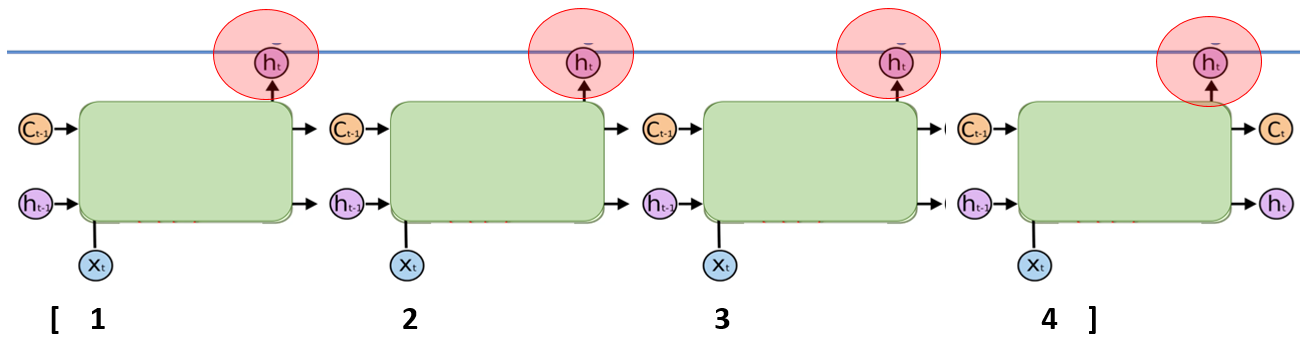

**Example Code:**


Since we have **4 time steps** and **unit (dimensionality of the output space)** is set to 16, the output shape will be (None, 4, 16). 

Because LSTM returns **1 hidden state**  for **each time step.**

In [ ]:
input =Input(shape=(n_timesteps_in, n_features))
all_state_h= LSTM(cell_size, return_sequences=True) (input)
model1 = Model(inputs=input, outputs=all_state_h)
model1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 30, 50)]          0         
                                                                 
 lstm_12 (LSTM)              (None, 30, 32)            10624     
                                                                 
Total params: 10,624
Trainable params: 10,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result=model1.predict(X_train)

print('input shape:  ', X_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample: \n', result[0])
print('\nhidden states for the first sample at the second time step: \n', result[0][1])

result=model1.predict(CX_train)

print('input shape:  ', CX_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample: \n', result[0])
print('\nhidden states for the first sample at the second time step: \n', result[0][1])

16/16 [==============================] - 0s 2ms/step
input shape:   (500, 30, 50)
all_state_h shape:  (500, 30, 32)

hidden states for the first sample: 
 [[ 1.48061275e-01 -1.60009677e-07  5.70977807e-01  5.26212109e-03
   7.55098403e-01 -4.03068443e-05 -5.37216512e-16  6.48885369e-01
  -2.70895976e-17  1.36743682e-02 -6.13226831e-01  3.44135836e-02
  -1.11654517e-03  3.55314626e-03  1.55623115e-04 -2.77038254e-07
  -2.70487443e-02  2.12594409e-06 -7.33064234e-01  7.85822795e-06
   6.63974431e-10 -7.44448483e-01  2.13346421e-03 -5.22109474e-07
  -1.16925030e-07 -2.06839949e-01 -1.69877640e-05  7.34230340e-01
  -1.84574109e-02 -1.60645044e-07 -1.10926749e-06  6.15023382e-05]
 [ 1.54955601e-02 -2.07495049e-01  1.22782506e-01  3.60287889e-03
   7.87338614e-02 -7.26816535e-01 -5.57339117e-05  8.96160841e-01
   7.43508921e-10  1.11220246e-02 -1.45185245e-02 -7.46752203e-01
  -2.06966743e-01  5.47226183e-02  7.04292188e-06 -1.54951249e-05
   2.13804111e-01 -8.89481902e-02 -8.55862141e-01  1

### 4.2.3.LSTM  return_state=True value:

When **return_state parameter is True**, it will output the **last** hidden state twice and the **last** cell state as the output from LSTM layer.


The ouput is a **three 2D-arrays** of real numbers.

The **first dimension** is indicating the number of samples (batch size) given to the LSTM layer


The **second dimension** is the **dimensionality of the output space** defined by **unit** parameter in the Keras LSTM layer. 


It returns 3 arrays in the result:

1. The LSTM hidden state of the last time step: (None, 16) It is 16 because **dimensionality of the output space (unit parameter)** is set to 16.

2. The LSTM hidden state of the last time step (again):(None, 16) 

3. The LSTM cell state of the last time step: (None, 16) refers last **cell state** value whose **dimensionality of the output space (unit parameter)** is set to 16.


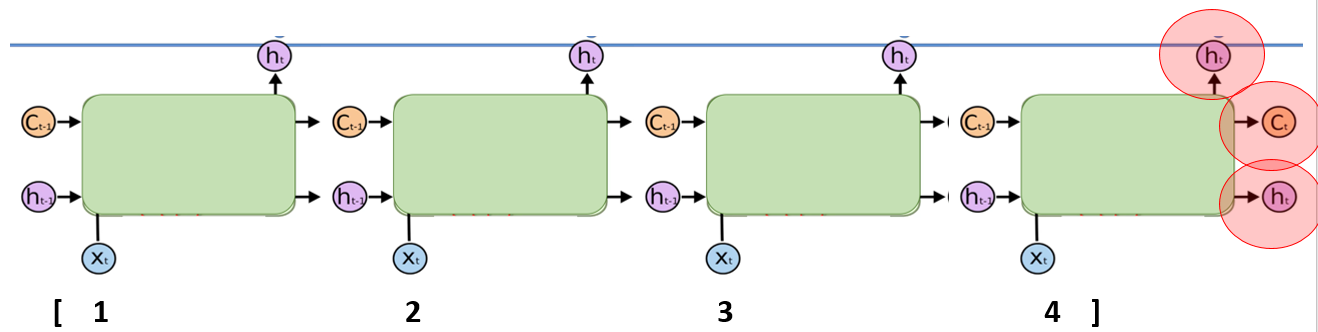

**Example Code:**

Since we set **unit parameter (dimensionality of the output space)**  to 16, the output shape will be (None, 16) for all 3 tensors. 


In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
LSTM_output, state_h, state_c= LSTM(cell_size, return_state=True) (input)
model1 = Model(inputs=input, outputs=[LSTM_output, state_h, state_c])
model1.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 30, 50)]          0         
                                                                 
 lstm_13 (LSTM)              [(None, 32),              10624     
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 10,624
Trainable params: 10,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.get_layer(index=1).output_shape

[(None, 32), (None, 32), (None, 32)]

In [ ]:
print("Input layer output shape: ", model1.get_layer(index=0).output_shape)
print("LSTM layer output shape: ", model1.get_layer(index=1).output_shape)

results=model1.predict(X_train)
results=array(results)
print("\nWith batch of data:")
print('input shape:  ', X_train.shape)
print('result is 3 2D-array: ', results.shape)
print('\nLSTM_output is in the first array: ', results[0].shape)
print('\nstate_h which is exactly the same with LSTM_output is in the second array: ', results[1].shape)
print('\nIs the content of LSTM_output and state_h  exactly the same?\n ', results[0]==results[1])
print('\nstate_c is in the third array: ', results[2].shape)


results=model1.predict(CX_train)
results=array(results)
print("\nWith batch of data:")
print('input shape:  ', X_train.shape)
print('result is 3 2D-array: ', results.shape)
print('\nLSTM_output is in the first array: ', results[0].shape)
print('\nstate_h which is exactly the same with LSTM_output is in the second array: ', results[1].shape)
print('\nIs the content of LSTM_output and state_h  exactly the same?\n ', results[0]==results[1])
print('\nstate_c is in the third array: ', results[2].shape)

Input layer output shape:  [(None, 30, 50)]
LSTM layer output shape:  [(None, 32), (None, 32), (None, 32)]
16/16 [==============================] - 0s 2ms/step

With batch of data:
input shape:   (500, 30, 50)
result is 3 2D-array:  (3, 500, 32)

LSTM_output is in the first array:  (500, 32)

state_h which is exactly the same with LSTM_output is in the second array:  (500, 32)

Is the content of LSTM_output and state_h  exactly the same?
  [[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

state_c is in the third array:  (500, 32)
16/16 [==============================] - 0s 2ms/step

With batch of data:
input shape:   (500, 30, 50)
result is 3 2D-array:  (3, 500, 32)

LSTM_output is in the first array:  (500, 32)

state_h which is exactly the same with LSTM_output is in the s

### 4.2.4.LSTM  return_state=True + return_sequences=True value:

**return_state and return_sequences parameters can be True at the same time**. 

In this situation, LSTM layer returns **3 results:** 

(as return_sequences=True)
1. the hidden states for each input time step, 

(as return_state=True)
2. the hidden state output for the last time step and 
3. the cell state for the last time step. 



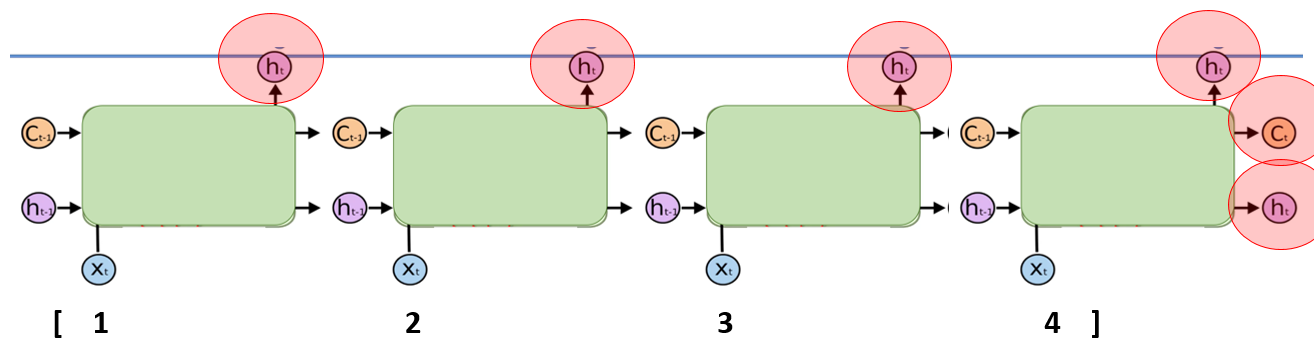

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
all_state_h, state_h, state_c= LSTM(cell_size, return_sequences=True, return_state=True) (input)
model1 = Model(inputs=input, outputs=[all_state_h, state_h, state_c])
model1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 30, 50)]          0         
                                                                 
 lstm_14 (LSTM)              [(None, 30, 32),          10624     
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 10,624
Trainable params: 10,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print("Input layer output shape: ", model1.get_layer(index=0).output_shape)
print("LSTM layer output shape: ", model1.get_layer(index=1).output_shape)

Input layer output shape:  [(None, 30, 50)]
LSTM layer output shape:  [(None, 30, 32), (None, 32), (None, 32)]


In [ ]:
results=model1.predict(X_train)
print("\nWith batch of data:")
print('input shape:  ', X_train.shape)
print('result is 3 2D-array len (results): ', len (results))
print('\nall_state_h is in the first array: ', results[0].shape)
print('\nstate_h  is in the second array: ', results[1])
print('\nstate_c is in the third array: ', results[2].shape)

results=model1.predict(CX_train)
print("\nWith batch of data:")
print('input shape:  ', CX_train.shape)
print('result is 3 2D-array len (results): ', len (results))
print('\nall_state_h is in the first array: ', results[0].shape)
print('\nstate_h  is in the second array: ', results[1])
print('\nstate_c is in the third array: ', results[2].shape)


16/16 [==============================] - 0s 2ms/step

With batch of data:
input shape:   (500, 30, 50)
result is 3 2D-array len (results):  3

all_state_h is in the first array:  (500, 30, 32)

state_h  is in the second array:  [[ 2.1550574e-04  1.3502121e-01  7.6285505e-05 ... -5.3719826e-02
   7.3906280e-02 -9.6193236e-01]
 [-1.7291467e-01 -1.0893407e-06  1.9165582e-03 ... -1.6074198e-01
   2.2304662e-01  9.0915728e-01]
 [ 3.8549360e-06 -1.4697972e-03  4.6740625e-02 ...  9.2682207e-01
   2.6812777e-02 -4.2514410e-02]
 ...
 [ 3.3676624e-03  5.2802525e-02  9.8149171e-03 ...  6.8978267e-07
  -2.7042071e-05 -8.4351236e-04]
 [ 8.0752233e-03 -3.5717338e-01  2.7507830e-02 ...  5.8840048e-03
  -9.4349623e-02 -4.4840670e-01]
 [ 6.7895673e-02  4.6681308e-09  4.3488187e-01 ... -2.3072964e-04
  -4.8830185e-02 -5.4156429e-01]]

state_c is in the third array:  (500, 32)
16/16 [==============================] - 0s 2ms/step

With batch of data:
input shape:   (500, 30, 50)
result is 3 2D-array len (

## 4.3.CONCLUSION
* There are 4 possible outputs from LSTM layer
* Important parameters are
  * units (dimensionality of the output space)
  * return_sequences
  * return_state
* return_sequences and return_state parameters default values are FALSE
* Combination of TRUE and FALSE values for return_sequences and return_state parameters generates different set of outputs
* units (dimensionality of the output space) parameter defines how many numbers in the resulting tensor (representing a hidden or cell state value) will be


## 4.4.INTRODUCTION BIDIRECTIONAL LSTM 



### 4.4.1.Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

Bidirectional recurrent neural networks(RNN) are really just putting two independent RNNs together. The input sequence is fed in normal time order for one network, and in reverse time order for another. The outputs of the two networks are usually concatenated at each time step.




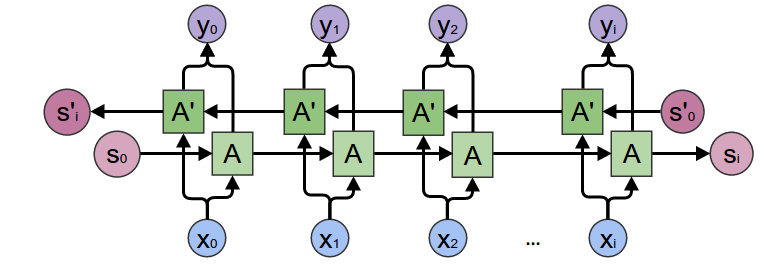

Bidirectional LSTM involves duplicating the first recurrent layer in the 
network so that there are now **two layers** side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

-It will create **two copies of the hidden layer**, one fit in the input sequences as-is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be **concatenated**

### 4.4.2.BİLSTM with Default return value:
As you remember, when we use lstm with default values, the output shape was **(None,16)** because each cell creates a number for hidden state. However, when we use bidirectional lstm each cell crates **two hidden states and concatenate them**. Thats why the output shape is **(None,32)**. 


* Using bidirectional will run your inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards you preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future.


In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))

model1 = Sequential()
model1.add(Bidirectional(LSTM(cell_size), input_shape=(n_timesteps_in, n_features)))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

result=model1.predict(X_test)
result

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 64)               21248     
 nal)                                                            
                                                                 
Total params: 21,248
Trainable params: 21,248
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 586ms/step


array([[ 4.21557613e-02,  1.29535518e-04,  6.52045419e-04,
         4.28241774e-12, -1.90260724e-11,  6.97746515e-01,
         6.32652164e-01,  3.98102611e-01,  7.73419917e-01,
         2.70278539e-11,  6.23552859e-01, -2.74003537e-06,
        -7.24367919e-06,  1.29304171e-01,  7.66438679e-05,
        -4.23588663e-01, -2.86774784e-01, -8.10598671e-01,
        -4.05614813e-11,  2.28481986e-06, -2.18254654e-03,
         3.72048393e-02, -7.65003800e-01,  2.28615617e-03,
         6.88168366e-05,  5.67099312e-03, -4.62466059e-03,
         2.16379404e-01, -6.08087599e-01, -2.92323623e-03,
         1.22770725e-05, -5.34337498e-02, -7.61201739e-01,
         8.55703413e-01,  1.41735666e-03,  1.03171849e-04,
         7.29836174e-08,  1.31629910e-02,  7.46967318e-03,
         4.55912799e-01, -7.54183829e-01, -9.98422742e-01,
        -8.86919320e-01, -5.53149402e-01, -2.77354687e-01,
        -9.59181011e-01, -2.74000794e-01,  8.98749948e-01,
         7.63305461e-11,  3.59260850e-02,  4.30544419e-0

### 4.4.3.BİLSTM return_sequences=True value:
This time it outputs **all the hidden** states from lstm layer because of the **return_sequence** parameter is **True**. That means it will return all hidden states for each time step in the cell. However this time since we're using **bidirectional lstm** the output shape will be **(None, 4, 32)**. Because there are **2 hidden states** for each cell.

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))

model1 = Sequential()
model1.add(Bidirectional(LSTM(cell_size, return_sequences=True), input_shape=(n_timesteps_in, n_features)))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

result=model1.predict(X_test)

print('input shape:  ', X_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample/input: \n', result[0])
print('\nhidden states of 16 units for the first sample/input at the second time step: \n', result[0][1])
print('\nhidden state of 3rd cell for the first sample/input at the second time step: \n', result[0][1][2])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 30, 64)           21248     
 nal)                                                            
                                                                 
Total params: 21,248
Trainable params: 21,248
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 583ms/step
input shape:   (500, 30, 50)
all_state_h shape:  (5, 30, 64)

hidden states for the first sample/input: 
 [[ 1.2902923e-04 -7.5063609e-02  7.5611949e-01 ... -7.5104719e-01
  -6.4167915e-10 -2.0169633e-05]
 [ 8.6541545e-01 -1.3373480e-02  7.6160443e-01 ... -8.8345248e-01
   1.5047862e-04 -1.3045309e-01]
 [ 1.9755309e-06 -7.8465921e-01  7.4994737e-01 ... -3.3790923e-03
  -7.6154900e-01 -2.6991495e-01]
 ...
 [-4.2225692e-02 -3.7389302e-01  8.5016936e-01 ... 

### 4.4.4.BİLSTM return_state=True value:

**Sequential model** is not straightforward to define models that may have multiple different input sources, produce multiple output destinations or models that re-use layers.

**Functional model** allows you to define multiple input or output models as well as models that share layers. Therefore, when we use the return_state parameter to be true, we must use the functional api.

In LSTM when the return_state parameter is true it returns 3 arrays in the result:
* The LSTM hidden state output for the last time step. 
* The LSTM hidden state output for the last time step (again). 
* The LSTM cell state for the last time step.

However when we use the Bidirectional LSTM it returns 5 arrays in the result : 
* The hidden states for last time step, by default it'll be the concatenation of forward and backward states.
* The last hidden state h for the forward LSTM
* The last cell state c for the forward LSTM
* The last hidden state h for the backward LSTM
* The last cell state c for the backward LSTM

If you want to merge the states, you can concatenate the forward and backward states with **Concatenate layers**.

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
last_states_h,forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(cell_size, return_state=True))(input)
#state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
#state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

model1 = Model(inputs=input, outputs=[last_states_h,forward_h, forward_c, backward_h, backward_c ])

model1.summary()

for layer in model1.layers:
    print(layer.output_shape)

result=model1.predict(X_test)




Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 30, 50)]          0         
                                                                 
 bidirectional_9 (Bidirectio  [(None, 64),             21248     
 nal)                         (None, 32),                        
                              (None, 32),                        
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 21,248
Trainable params: 21,248
Non-trainable params: 0
_________________________________________________________________
[(None, 30, 50)]
[(None, 64), (None, 32), (None, 32), (None, 32), (None, 32)]
1/1 [==============================] - 1s 596ms/step


### 4.4.5.BİLSTM  return_state=True + return_sequences=True value:

The call *Bidirectional(LSTM(numberOfLSTMunits, return_sequences=True, return_state=True))(input)* returns **5 tensors**:

* The entire sequence of hidden states, by default it'll be the concatenation of forward and backward states.
* The last hidden state h for the forward LSTM
* The last cell state c for the forward LSTM
* The last hidden state h for the backward LSTM
* The last cell state c for the backward LSTM

To merge the states, we can concatenate the forward and backward states with **Concatenate** layers.

In [ ]:
# define model
input =Input(shape=(n_timesteps_in, n_features))

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(cell_size,return_sequences=True, return_state=True))(input)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

model1 = Model(inputs=input, outputs=[state_h, state_c])

model1.summary()

for layer in model1.layers:
    print(layer.output_shape)

result=model1.predict(X_test)

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 30, 50)]     0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  [(None, 30, 64),    21248       ['input_18[0][0]']               
 l)                              (None, 32),                                                      
                                 (None, 32),                                                      
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                           

# 5.LSTM Anomaly model (State management)

## 5.1.Model layers



In [ ]:
num_outputs = 10
# Define input layers
input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
#seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

# Preprocess observation with a hidden layer and send to LSTM cell
dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
lstm_out, state_h, state_c = tf.keras.layers.LSTM(
    cell_size, return_sequences=True, return_state=True, name="lstm")(
    inputs=dense1,
    #mask=tf.sequence_mask(seq_in),
    initial_state=[state_in_h, state_in_c]
    )

# Postprocess LSTM output with another hidden layer and compute values
logits = tf.keras.layers.Dense(
    num_outputs,
    activation=tf.keras.activations.linear,
    name="logits")(lstm_out)
values = tf.keras.layers.Dense(
    1, activation="sigmoid", name="values")(lstm_out)

# Create the RNN model
model5: Model = Model(
    inputs=
    [
      input_layer, #seq_in,
      state_in_h,
      state_in_c
    ],
    outputs=[logits, values, state_h, state_c])
model5.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 50)]   0           []                               
                                                                                                  
 dense1 (Dense)                 (None, None, 256)    13056       ['inputs[0][0]']                 
                                                                                                  
 h (InputLayer)                 [(None, 32)]         0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 32)]         0           []                               
                                                                                           

## 5.2.Train



#h= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 0. 0. 0.]


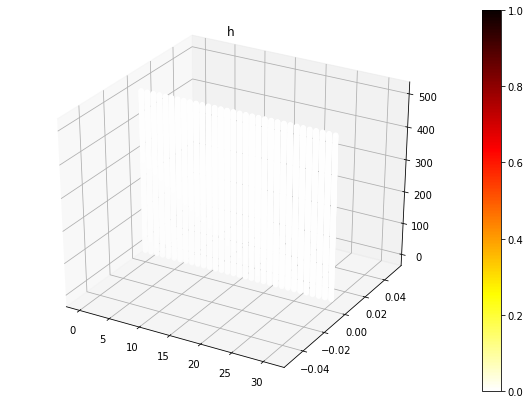

#c= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 0. 0. 0.]


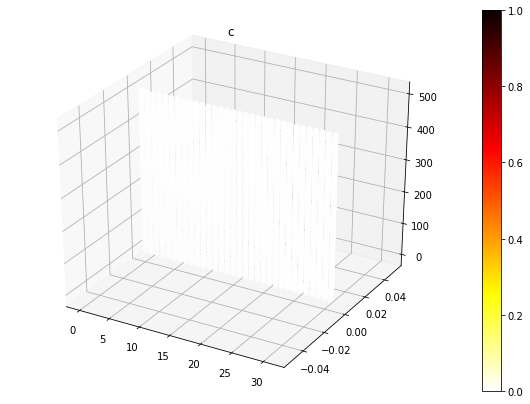

#X_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [ 2  2 26 ... 10 10  2]


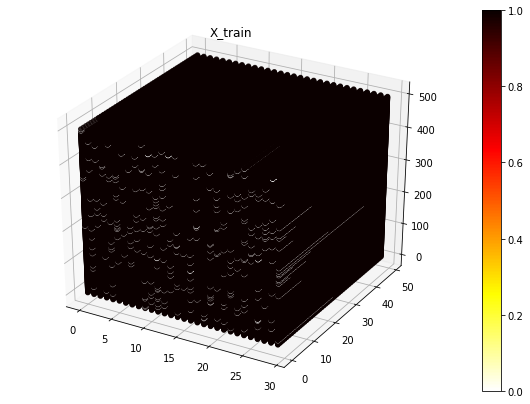

#y_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [1 0 0 ... 0 0 0]


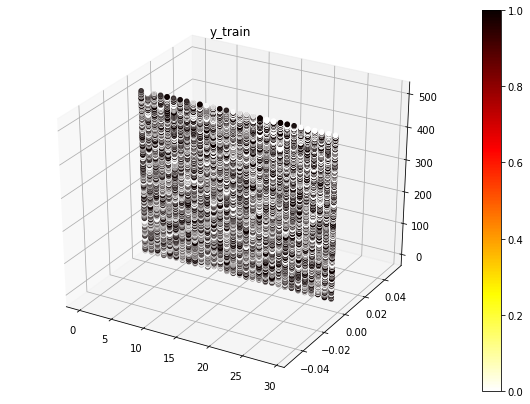

16/16 [==============================] - 0s 4ms/step
#y_train_predicted= (500, 30, 1)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.49909326 0.5042771  0.54016155 ... 0.5090345  0.5199522  0.50082785]


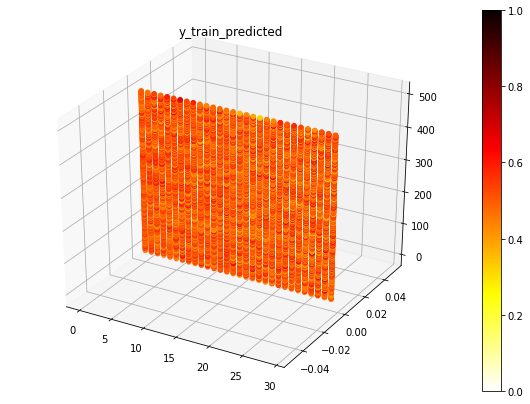

#y_train_h= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [-1.8928045e-02 -2.6238248e-01  1.6781962e-02 ... -1.3738413e-02
 -3.9575887e-03 -3.1458508e-06]


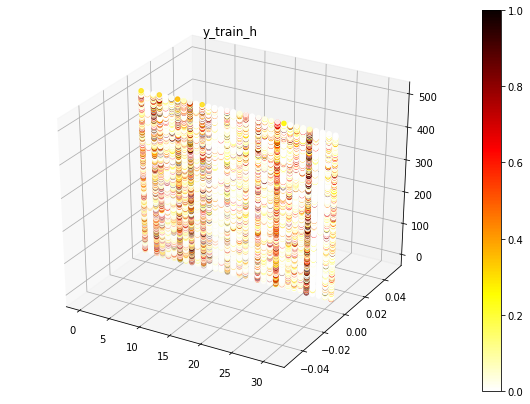

#y_train_c= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [-1.9655634e-02 -4.0079637e+00  6.3446164e-02 ... -1.3850748e-02
 -7.6191455e-01 -4.0612344e-04]


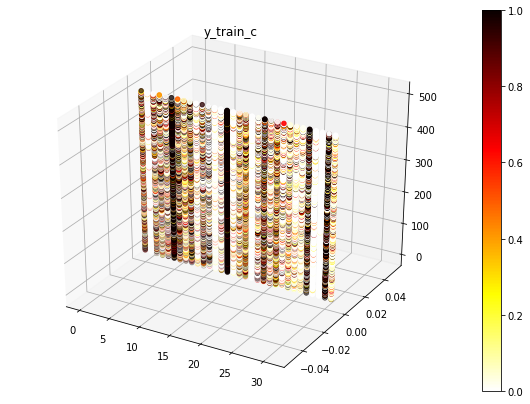

#CX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 0. 0. 0.]


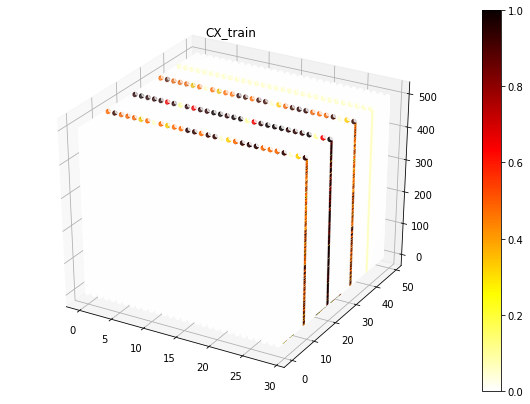

#Cy_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 1. 1. 1.]


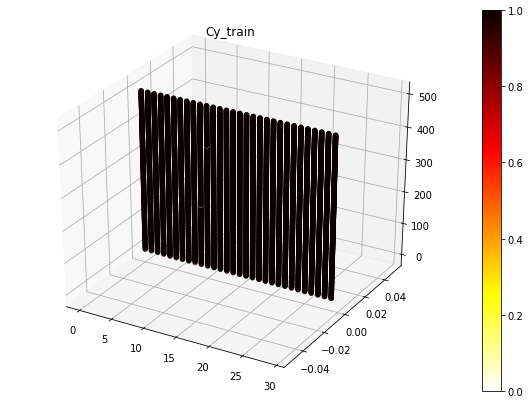

16/16 [==============================] - 0s 5ms/step
#Cy_train_predicted= (500, 30, 1)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.49811456 0.49316195 0.4872586  ... 0.5177276  0.51671183 0.5203938 ]


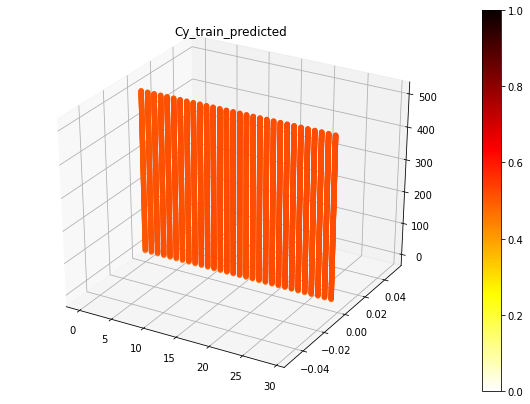

#Cy_train_h= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [ 0.0381335  -0.03753256  0.01825641 ... -0.00137978  0.09460699
  0.0611887 ]


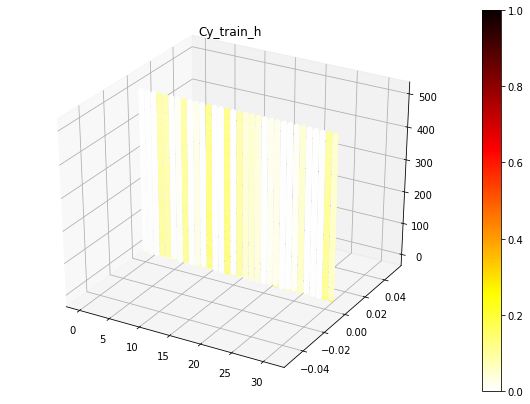

#Cy_train_c= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [ 0.07387079 -0.07592349  0.0358594  ... -0.00252697  0.20242362
  0.12462153]


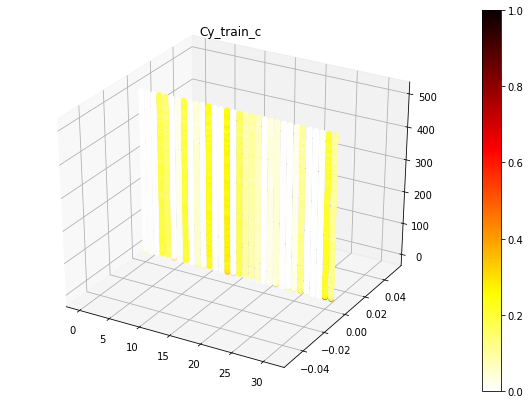

#LX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.76837158e-05 0.00000000e+00]


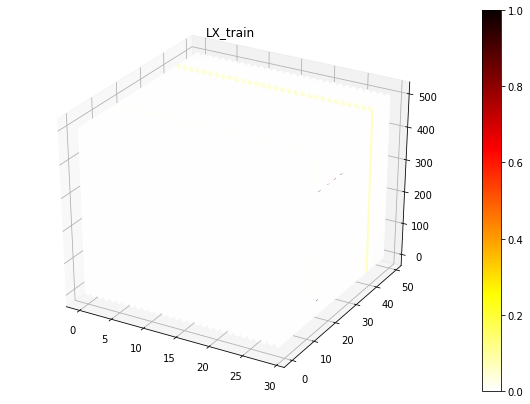

#Ly_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [ 0.  0.  0. ... nan nan nan]


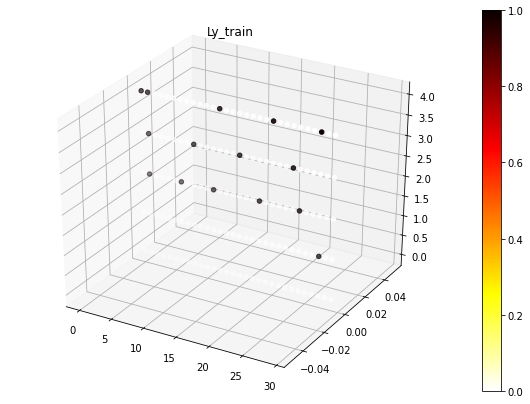

16/16 [==============================] - 0s 6ms/step
#Ly_train_predicted= (500, 30, 1)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.4999166  0.4999448  0.500435   ... 0.5004588  0.50045854 0.50045896]


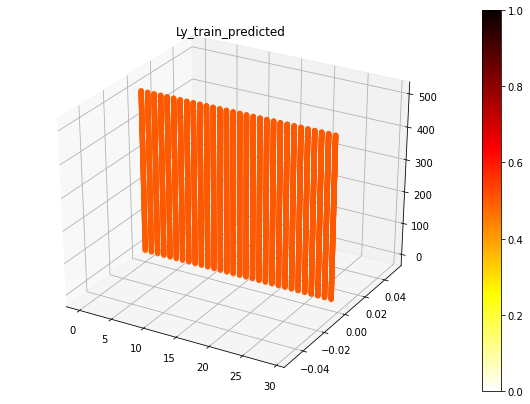

#Ly_train_h= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [-0.00436181 -0.00270166  0.00478932 ...  0.00440593  0.00892893
 -0.00048565]


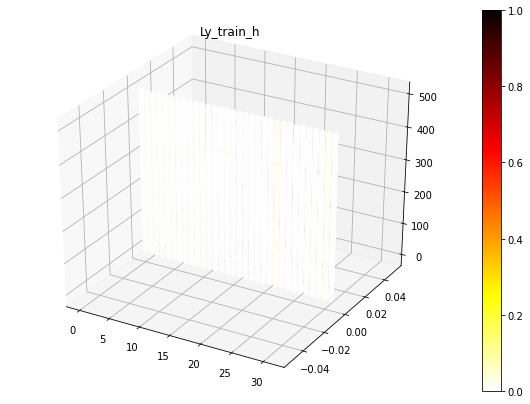

#Ly_train_c= (500, 32)
x= [ 0  1  2 ... 29 30 31]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [-0.00873478 -0.00539979  0.00960221 ...  0.00881173  0.01788942
 -0.00097008]


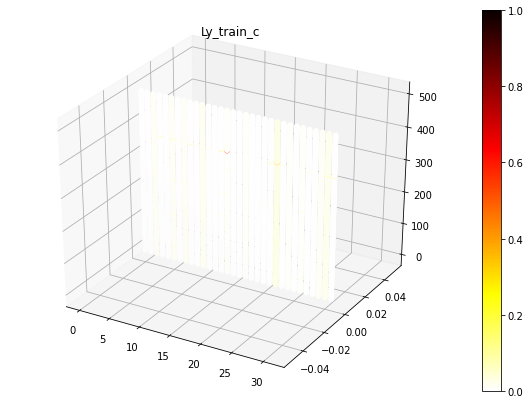

In [ ]:
model5.compile("adam", "binary_crossentropy", metrics=["accuracy"])

h = np.zeros((train_size, cell_size), np.float32)
c = np.zeros((train_size, cell_size), np.float32)
show_scattered_4d(h, "h")
show_scattered_4d(c, "c")

show_scattered_4d(X_train, 'X_train')
show_scattered_4d(y_train, "y_train")
compile5 = model5.predict([X_train, h, c])
show_scattered_4d(compile5[1], "y_train_predicted")
show_scattered_4d(compile5[2], "y_train_h")
show_scattered_4d(compile5[3], "y_train_c")


show_scattered_4d(CX_train, 'CX_train')
show_scattered_4d(Cy_train, "Cy_train")
C_compile5 = model5.predict([CX_train, h, c])
show_scattered_4d(C_compile5[1], "Cy_train_predicted")
show_scattered_4d(C_compile5[2], "Cy_train_h")
show_scattered_4d(C_compile5[3], "Cy_train_c")

show_scattered_4d(LX_train, 'LX_train')
show_scattered_4d(Ly_train, "Ly_train")
L_compile5 = model5.predict([LX_train, h, c])
show_scattered_4d(L_compile5[1], "Ly_train_predicted")
show_scattered_4d(L_compile5[2], "Ly_train_h")
show_scattered_4d(L_compile5[3], "Ly_train_c")

## 5.3.Infer



#LX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.95910645e-05 0.00000000e+00]


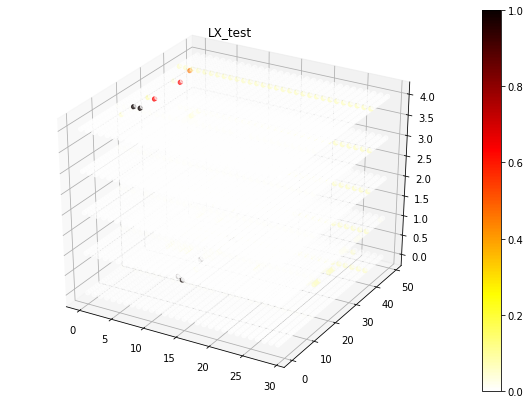

#Ly_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

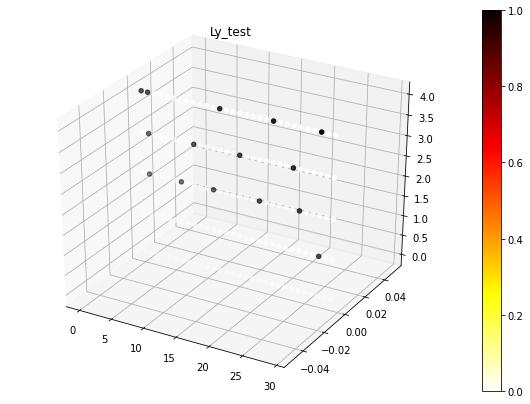

1/1 [==============================] - 0s 17ms/step
#Ly_test_predicted= (5, 30, 1)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 

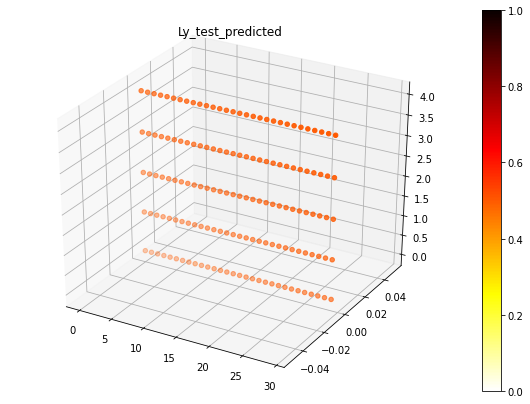

#Ly_test_h= (5, 32)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 

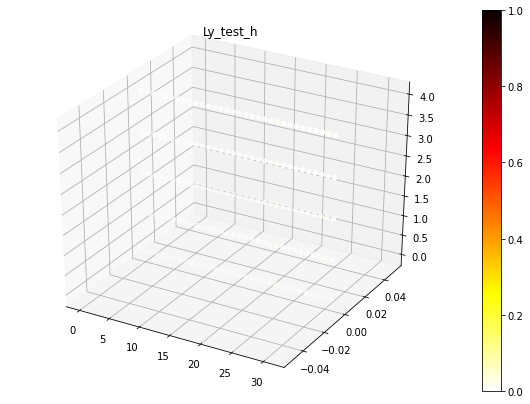

#Ly_test_c= (5, 32)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7
  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15
 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 

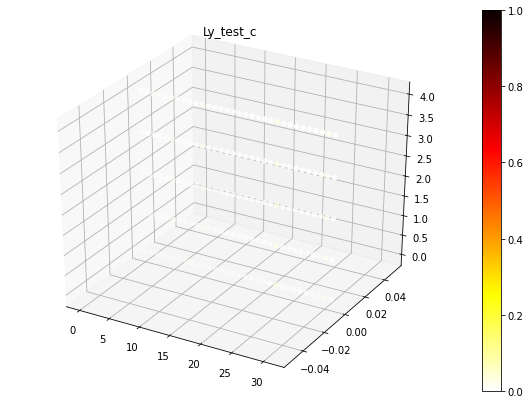

In [ ]:
h = np.zeros((predict_size, cell_size), np.float32)
c = np.zeros((predict_size, cell_size), np.float32)

show_scattered_4d(LX_test, "LX_test")
show_scattered_4d(Ly_test, "Ly_test")
L_infer5 = model5.predict([LX_test, h, c])
show_scattered_4d(L_infer5[1], "Ly_test_predicted")
show_scattered_4d(L_infer5[2], "Ly_test_h")
show_scattered_4d(L_infer5[3], "Ly_test_c")

In [ ]:
def infer(model):
  ##############X_train
  show_scattered_4d(X_train, "X_train")
  show_scattered_4d(y_train, "y_train")
  print("y_train=", y_train)

  result=model.predict(X_train)
  show_scattered_4d(result, "y_train_predicted")

  ##############X_test
  show_scattered_4d(X_test, "X_test")
  show_scattered_4d(y_test, "y_test")
  result=model.predict(X_test)
  show_scattered_4d(result, "y_test_predicted")


  ##############CX_train
  show_scattered_4d(CX_train, "CX_train")
  show_scattered_4d(Cy_train, "Cy_train")
  C_result=model.predict(CX_train)
  show_scattered_4d(C_result, "Cy_train_predicted")

  ##############CX_test
  show_scattered_4d(CX_test, "CX_test")
  show_scattered_4d(Cy_test, "Cy_test")
  C_result=model.predict(CX_test)
  show_scattered_4d(C_result, "Cy_test_predicted")

  ##############LX_train
  show_scattered_4d(LX_train, "LX_train")
  show_scattered_4d(Ly_train, "Ly_train")
  L_result=model.predict(LX_train)
  show_scattered_4d(L_result, "Ly_train_predicted")

  ##############LX_test
  show_scattered_4d(LX_test, "LX_test")
  show_scattered_4d(Ly_test, "Ly_test")
  L_result=model.predict(LX_test)
  show_scattered_4d(L_result, "Ly_test_predicted")

___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [ ]:
num_outputs = 10
# Define input layers
input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
#state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
#state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
#seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

# Preprocess observation with a hidden layer and send to LSTM cell
dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
lstm_out, state_h, state_c = tf.keras.layers.LSTM(
    cell_size, return_sequences=True, return_state=True, name="lstm")(
    inputs=dense1,
    #mask=tf.sequence_mask(seq_in),
    #initial_state=[state_in_h, state_in_c]
    )

# Postprocess LSTM output with another hidden layer and compute values
logits = tf.keras.layers.Dense(
    num_outputs,
    activation=tf.keras.activations.linear,
    name="logits")(lstm_out)
values = tf.keras.layers.Dense(
    1, activation="sigmoid", name="values")(lstm_out)

# Create the RNN model
model6: Model = Model(
    inputs=input_layer,
    #[
    #  input_layer, #seq_in,
    #  state_in_h,
    #  state_in_c
    #],
    outputs=values
    #[
    #  logits,
    #  values,
    #  state_h,
    #  state_c
    #]
    )
model6.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 50)]        0         
                                                                 
 dense1 (Dense)              (None, None, 256)         13056     
                                                                 
 lstm (LSTM)                 [(None, None, 32),        36992     
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
 values (Dense)              (None, None, 1)           33        
                                                                 
Total params: 50,081
Trainable params: 50,081
Non-trainable params: 0
_________________________________________________________________


## 6.2.Train



Epoch 1/10
16/16 [==============================] - 2s 36ms/step - loss: 0.4036 - accuracy: 0.8877 - val_loss: 0.7004 - val_accuracy: 0.3733
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0573 - accuracy: 0.9936 - val_loss: 0.3951 - val_accuracy: 0.8133
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0192 - accuracy: 0.9997 - val_loss: 0.1687 - val_accuracy: 0.9933
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0121 - accuracy: 0.9997 - val_loss: 0.1381 - val_accuracy: 0.9933
Epoch 5/10
16/16 [==============================] - 0s 18ms/step - loss: 0.0091 - accuracy: 0.9997 - val_loss: 0.1033 - val_accuracy: 0.9867
Epoch 6/10
16/16 [==============================] - 0s 19ms/step - loss: 0.0069 - accuracy: 0.9997 - val_loss: 0.0904 - val_accuracy: 0.9867
Epoch 7/10
16/16 [==============================] - 0s 12ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 0.0790 - val_accuracy: 0.9933
Epoch 8/10
16/16

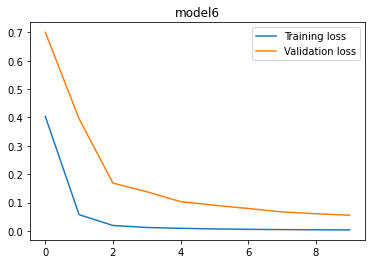

In [ ]:
# customAdam = tf.keras.optimizers.Adam(lr=0.0001) 
# model6.compile(optimizer=customAdam, 
#               # Loss function to minimize
#               loss="binary_crossentropy",
#               # List of metrics to monitor
#               metrics=[
#                   "accuracy",
#                   "mean_squared_error",
#                   "binary_crossentropy"
#               ])

# es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 5)
# print('# Fit model on training data')

# history = model6.fit(X_train,
#                     y_train, 
#                     batch_size=512, 
#                     epochs=50,
#                     validation_split=0.1,
#                     callbacks = [es]
#                    )

model6.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model6.fit(CX_train, Cy_train, batch_size=32, epochs=10, validation_data=(CX_test, Cy_test))
show_train_metric(history, "model6")

## 6.3.Infer



#X_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [ 2  2 26 ... 10 10  2]


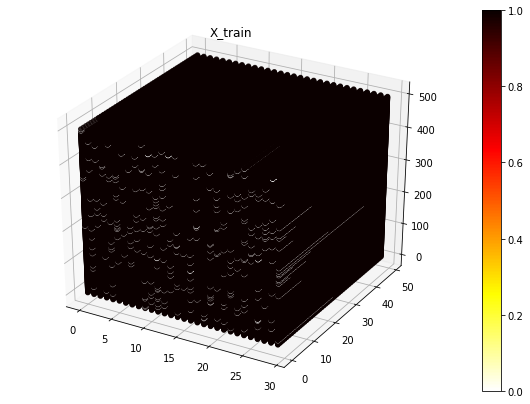

#y_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [1 0 0 ... 0 0 0]


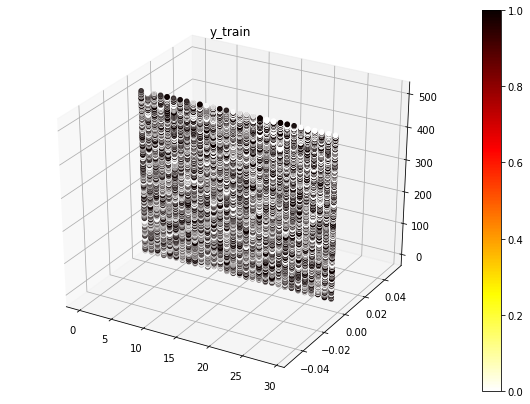

y_train= [[1 0 0 ... 0 1 0]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
16/16 [==============================] - 0s 4ms/step
#y_train_predicted= (500, 30, 1)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.9979785  0.99965537 0.9981489  ... 0.90066266 0.7420845  0.91526115]


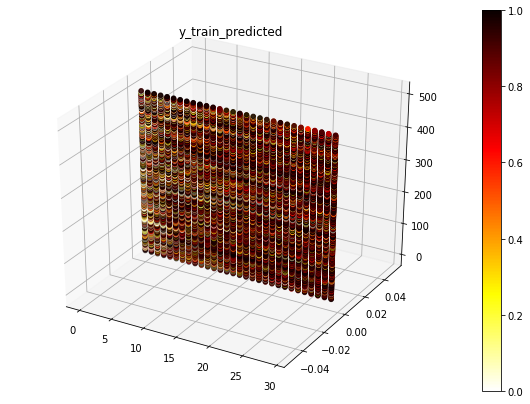

#X_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [ 2  2  4 ... 22  2  2]


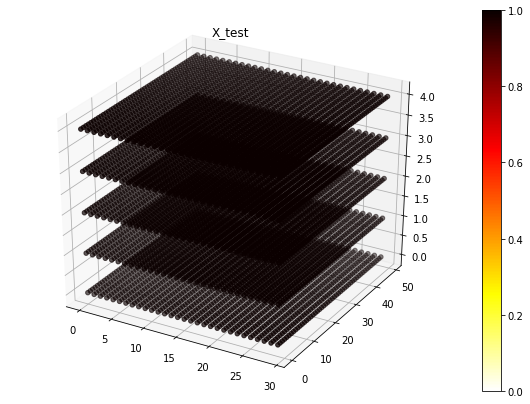

#y_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3

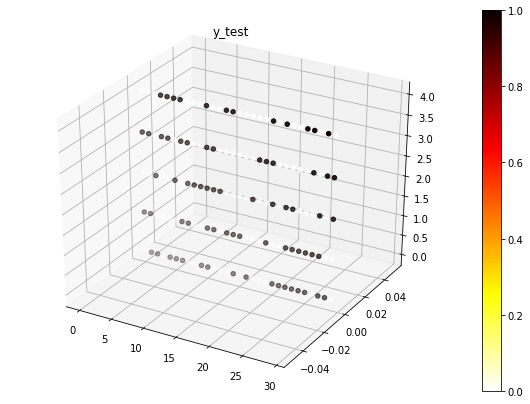

1/1 [==============================] - 0s 19ms/step
#y_test_predicted= (5, 30, 1)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2

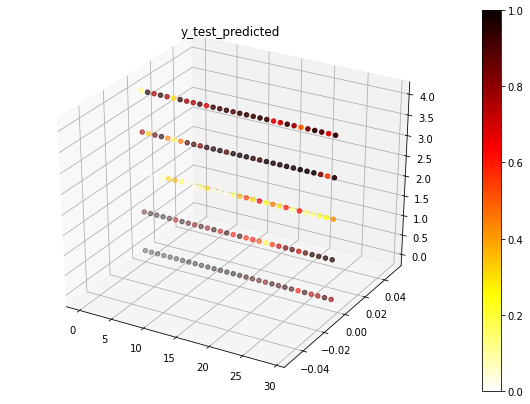

#CX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 0. 0. 0.]


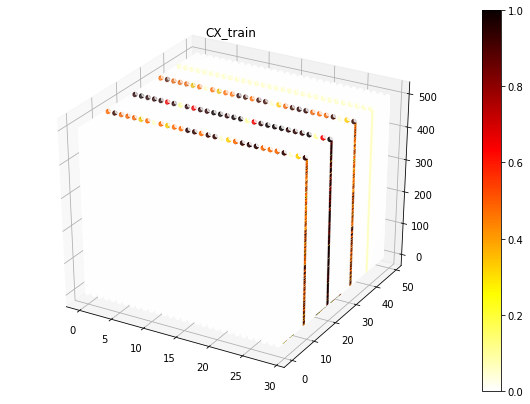

#Cy_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 1. 1. 1.]


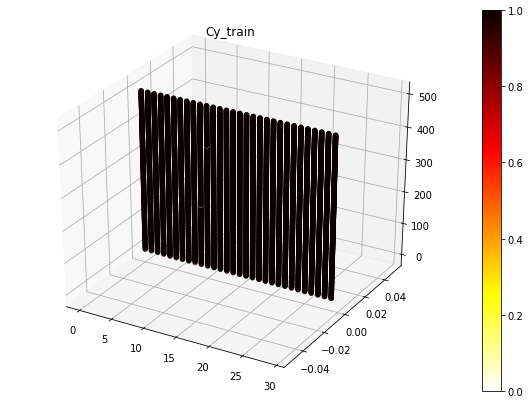

16/16 [==============================] - 0s 5ms/step
#Cy_train_predicted= (500, 30, 1)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.14580147 0.06347596 0.04379488 ... 0.9995171  0.9996673  0.999798  ]


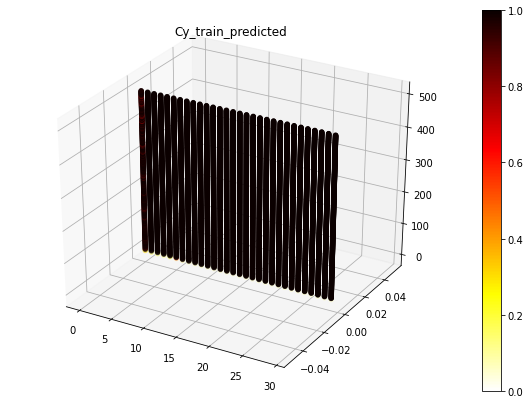

#CX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0. 0. 0. ... 0. 0. 0.]


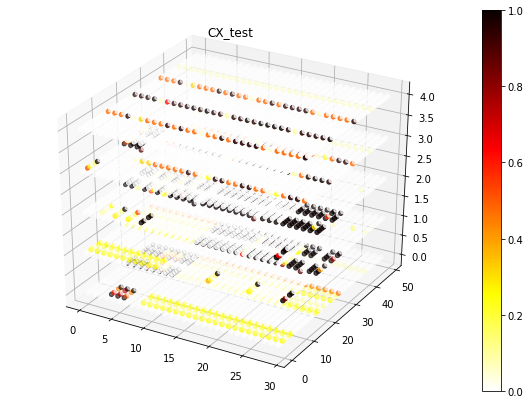

#Cy_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

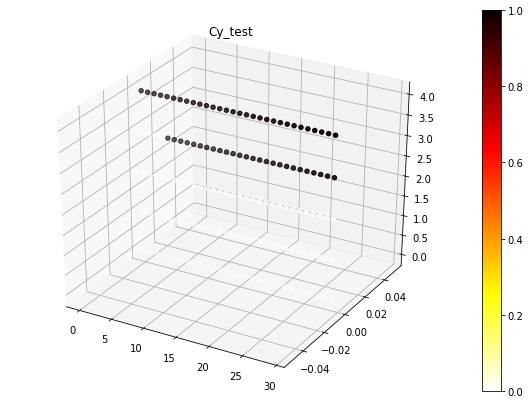

1/1 [==============================] - 0s 28ms/step
#Cy_test_predicted= (5, 30, 1)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 

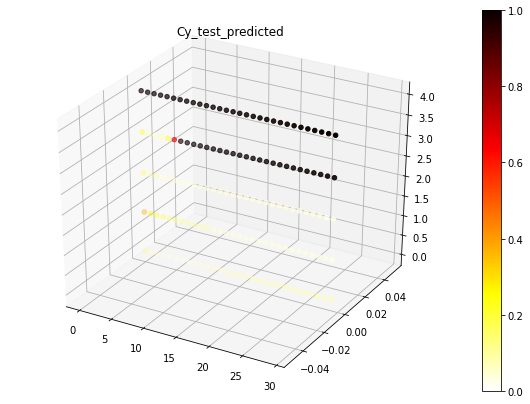

#LX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.76837158e-05 0.00000000e+00]


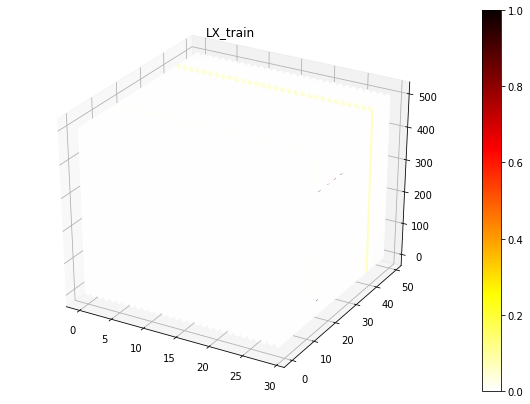

#Ly_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [ 0.  0.  0. ... nan nan nan]


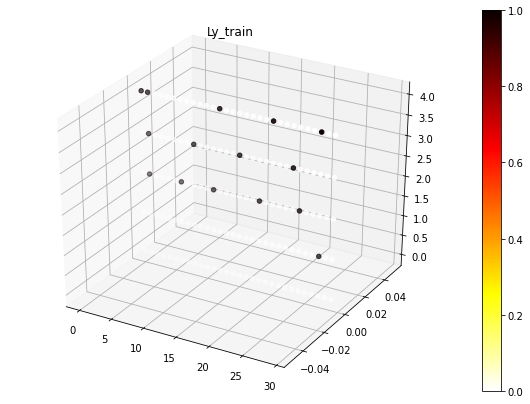

16/16 [==============================] - 0s 5ms/step
#Ly_train_predicted= (500, 30, 1)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.6968696  0.8374905  0.918887   ... 0.99889034 0.9988961  0.9989011 ]


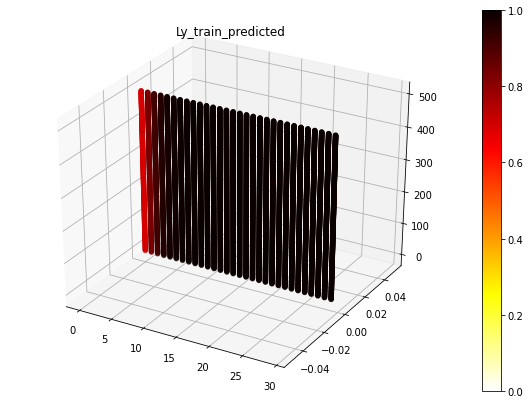

#LX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.95910645e-05 0.00000000e+00]


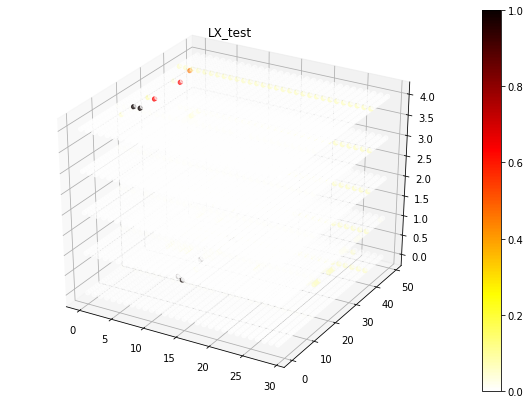

#Ly_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

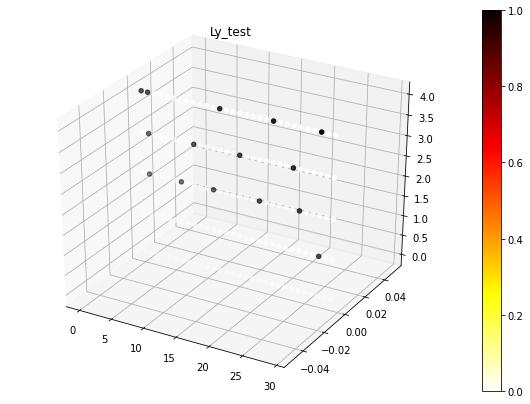

1/1 [==============================] - 0s 17ms/step
#Ly_test_predicted= (5, 30, 1)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 

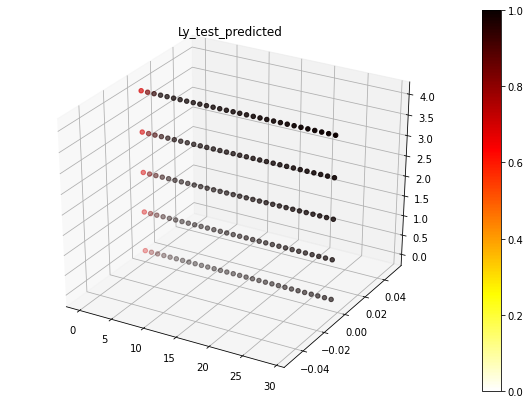

In [ ]:
infer(model6)

# 7.BIDIRECTIONAL LSTM ANOMALY MODEL (For compare only)

*   List item
*   List item





## 7.1.Model layers





In [ ]:
# Input for variable-length sequences of integers
#inputs = keras.Input(shape=(None, n_features), dtype="int32")
input = Input(shape=(n_timesteps_in, n_features))
# Embed each integer in a 128-dimensional vector
# x = layers.Embedding(n_features, n_features)(inputs)

# Add 2 bidirectional LSTMs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cell_size, return_sequences=True))(input)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cell_size))(x)
# Add a classifier
outputs = tf.keras.layers.Dense(n_timesteps_in, activation="sigmoid")(x)
model7 = keras.Model(input, outputs)
model7.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 30, 50)]          0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 30, 64)           21248     
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
Total params: 48,030
Trainable params: 48,030
Non-trainable params: 0
_________________________________________________________________


## 7.2.Train





Epoch 1/10
16/16 [==============================] - 7s 100ms/step - loss: 0.5939 - accuracy: 0.0000e+00 - val_loss: 0.5934 - val_accuracy: 0.0000e+00
Epoch 2/10
16/16 [==============================] - 0s 13ms/step - loss: 0.2778 - accuracy: 0.0000e+00 - val_loss: 0.4194 - val_accuracy: 0.0000e+00
Epoch 3/10
16/16 [==============================] - 0s 13ms/step - loss: 0.0918 - accuracy: 0.0000e+00 - val_loss: 0.3610 - val_accuracy: 0.0000e+00
Epoch 4/10
16/16 [==============================] - 0s 13ms/step - loss: 0.0374 - accuracy: 0.0000e+00 - val_loss: 0.3543 - val_accuracy: 0.0000e+00
Epoch 5/10
16/16 [==============================] - 0s 13ms/step - loss: 0.0230 - accuracy: 0.0000e+00 - val_loss: 0.3499 - val_accuracy: 0.0000e+00
Epoch 6/10
16/16 [==============================] - 0s 14ms/step - loss: 0.0175 - accuracy: 0.0000e+00 - val_loss: 0.3449 - val_accuracy: 0.0000e+00
Epoch 7/10
16/16 [==============================] - 0s 14ms/step - loss: 0.0147 - accuracy: 0.0000e+00 - 

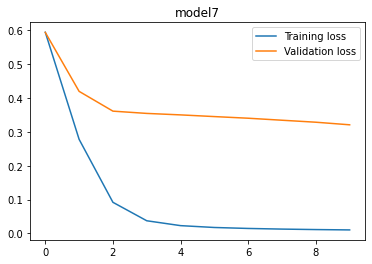

In [ ]:

model7.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model7.fit(CX_train, Cy_train, batch_size=32, epochs=10, validation_data=(CX_test, Cy_test))
show_train_metric(history, "model7")

## 7.3.Infer





#X_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [ 2  2 26 ... 10 10  2]


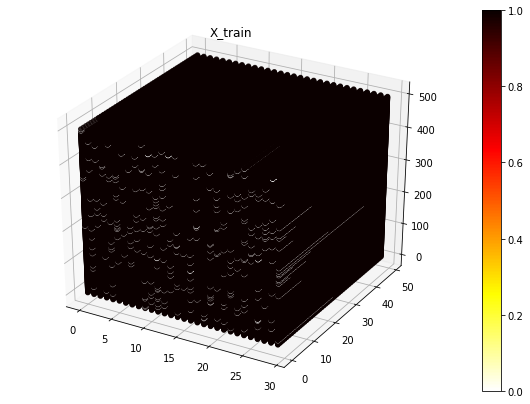

#y_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [1 0 0 ... 0 0 0]


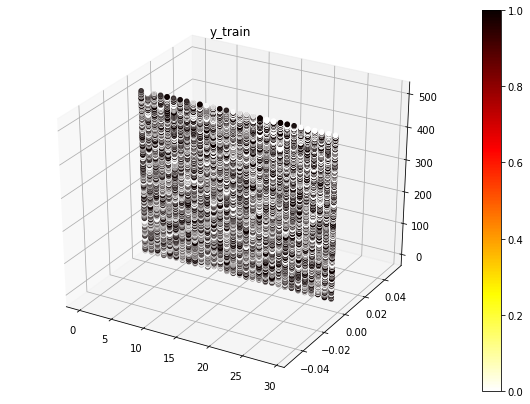

y_train= [[1 0 0 ... 0 1 0]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
16/16 [==============================] - 1s 5ms/step
#y_train_predicted= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.24053842 0.2777941  0.30659798 ... 0.26121563 0.3498385  0.35439295]


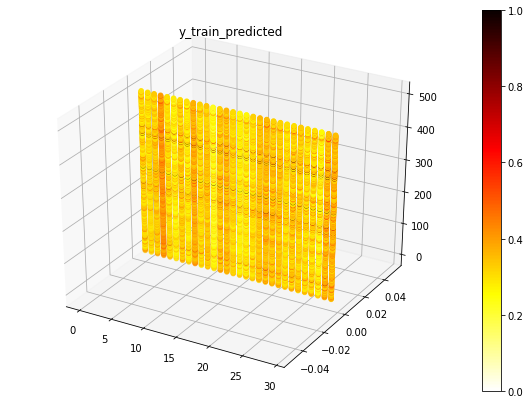

#X_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [ 2  2  4 ... 22  2  2]


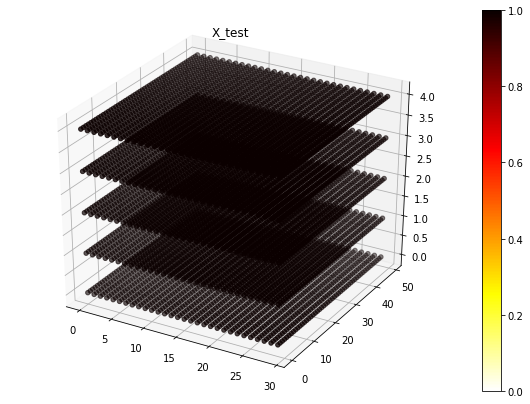

#y_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3

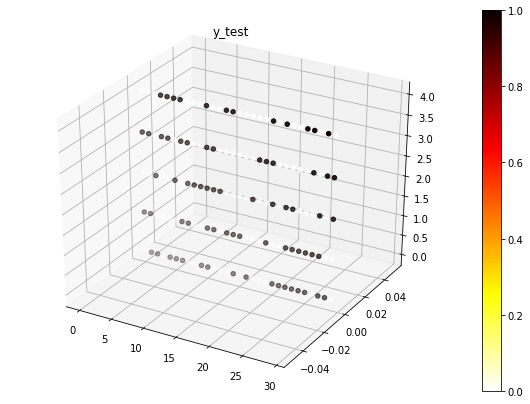

1/1 [==============================] - 0s 19ms/step
#y_test_predicted= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 

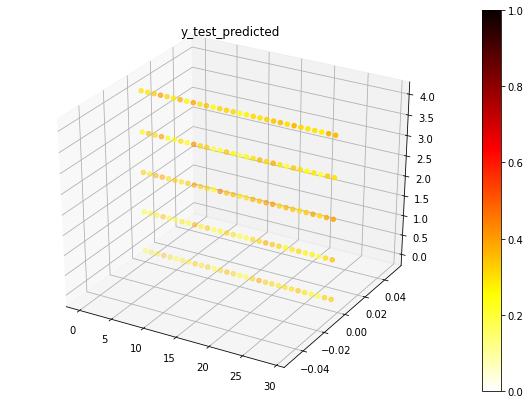

#CX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 0. 0. 0.]


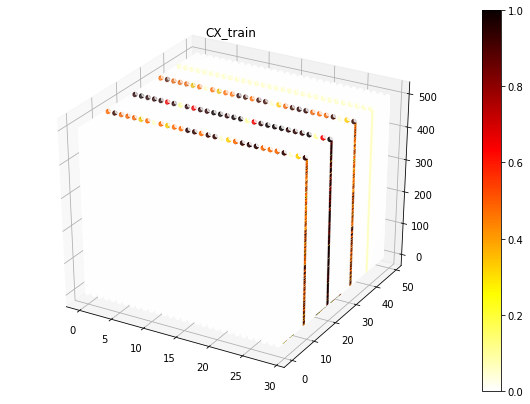

#Cy_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 1. 1. 1.]


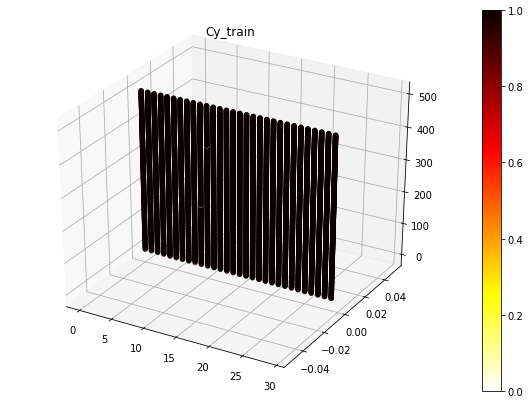

16/16 [==============================] - 1s 6ms/step
#Cy_train_predicted= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.25001454 0.28643724 0.28927886 ... 0.99868256 0.9952909  0.9935529 ]


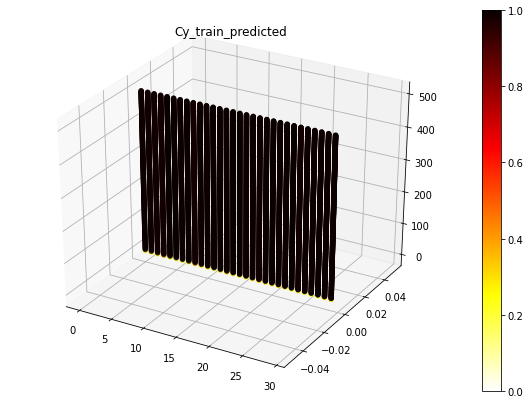

#CX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0. 0. 0. ... 0. 0. 0.]


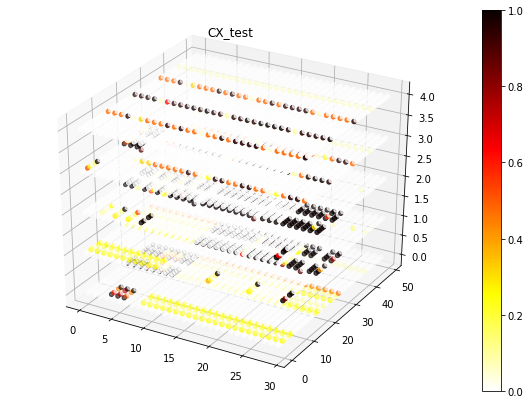

#Cy_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

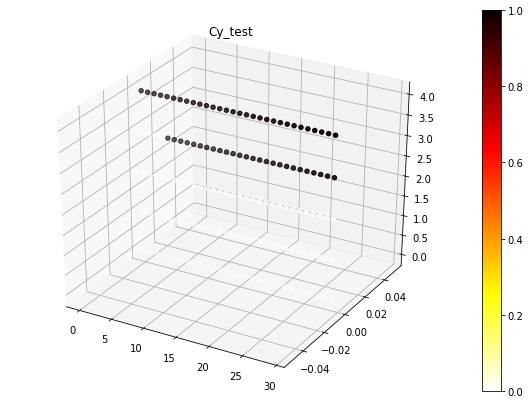

1/1 [==============================] - 0s 25ms/step
#Cy_test_predicted= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2

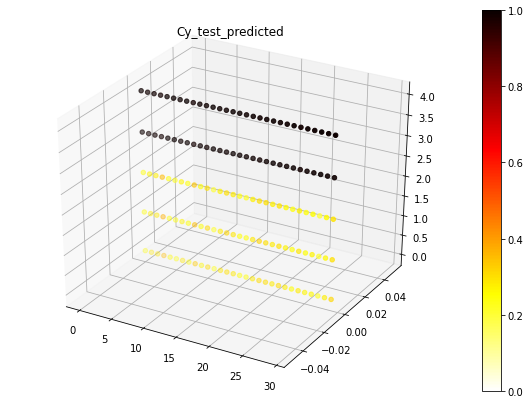

#LX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.76837158e-05 0.00000000e+00]


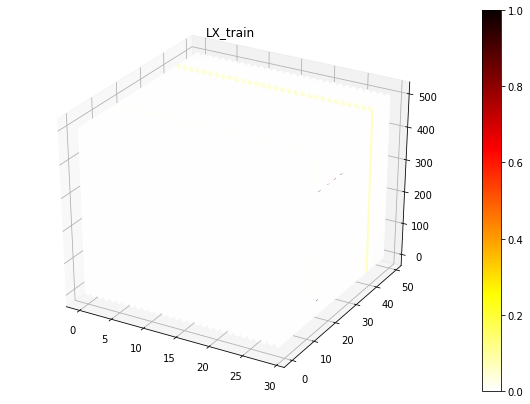

#Ly_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [ 0.  0.  0. ... nan nan nan]


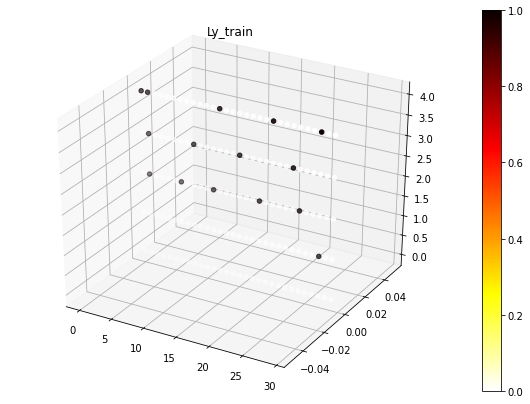

16/16 [==============================] - 0s 6ms/step
#Ly_train_predicted= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.9949882  0.99053663 0.99171805 ... 0.99865806 0.99520373 0.99344593]


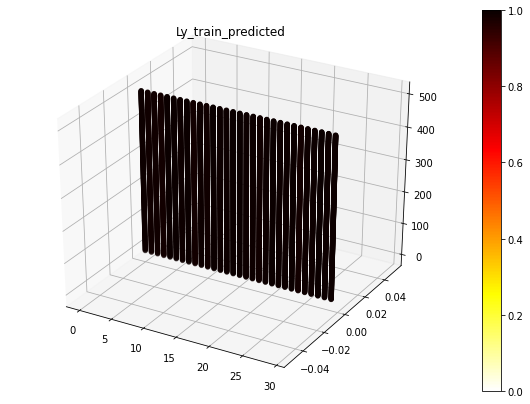

#LX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.95910645e-05 0.00000000e+00]


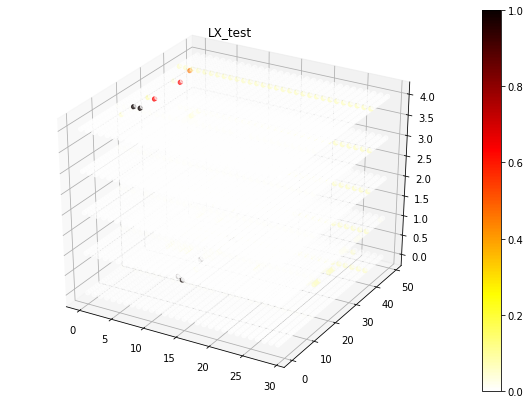

#Ly_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

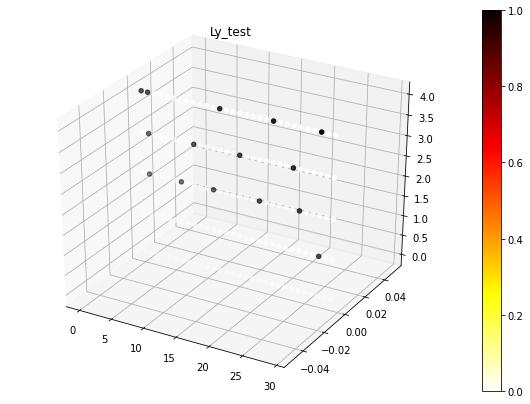

1/1 [==============================] - 0s 27ms/step
#Ly_test_predicted= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2

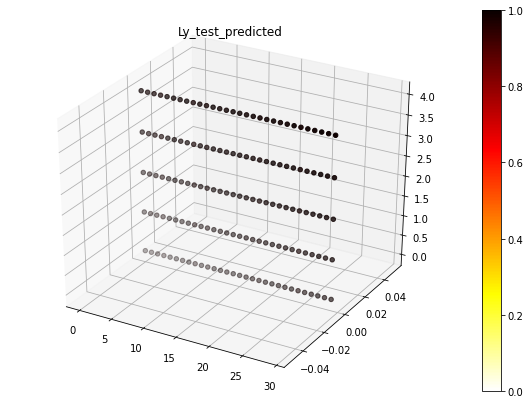

In [ ]:
infer(model7)

# 8.SEQUENCIAL BIDIRECTIONAL LSTM ANOMALY MODEL (For compare only)
https://github.com/aggpiyush/IDS-2018/blob/main/LSTM.ipynb



## 8.1.Model layers





In [ ]:
input = Input(shape=(n_timesteps_in, n_features))
model8 = tf.keras.Sequential([
    input,
    #tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1"),
    #tf.keras.layers.Embedding(n_features, cell_size, input_length=n_timesteps_in),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cell_size)),
    tf.keras.layers.Dense(cell_size, activation='relu'),
    tf.keras.layers.Dense(n_timesteps_in, activation='sigmoid')
    #tf.keras.layers.Dense(n_timesteps_in, activation='softmax') # loss too big
])
model8.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_13 (Bidirecti  (None, 64)               21248     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 30)                990       
                                                                 
Total params: 24,318
Trainable params: 24,318
Non-trainable params: 0
_________________________________________________________________


## 8.2.Training





Epoch 1/10
16/16 [==============================] - 3s 56ms/step - loss: 0.6542 - accuracy: 0.1660 - val_loss: 0.6708 - val_accuracy: 0.2000
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss: 0.4559 - accuracy: 0.9920 - val_loss: 0.5807 - val_accuracy: 0.2000
Epoch 3/10
16/16 [==============================] - 0s 8ms/step - loss: 0.1883 - accuracy: 0.9920 - val_loss: 0.5425 - val_accuracy: 0.2000
Epoch 4/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0601 - accuracy: 0.3860 - val_loss: 0.5406 - val_accuracy: 0.0000e+00
Epoch 5/10
16/16 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.0000e+00 - val_loss: 0.5511 - val_accuracy: 0.0000e+00
Epoch 6/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0119 - accuracy: 0.0000e+00 - val_loss: 0.5505 - val_accuracy: 0.0000e+00
Epoch 7/10
16/16 [==============================] - 0s 9ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.5490 - val_accuracy: 0.

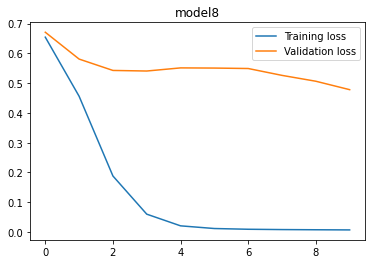

In [ ]:

model8.compile("adam", "binary_crossentropy", metrics=["accuracy"])
history = model8.fit(CX_train, Cy_train, batch_size=32, epochs=10, validation_data=(CX_test, Cy_test))
show_train_metric(history, "model8")

## 8.3.Infer





#X_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [ 2  2 26 ... 10 10  2]


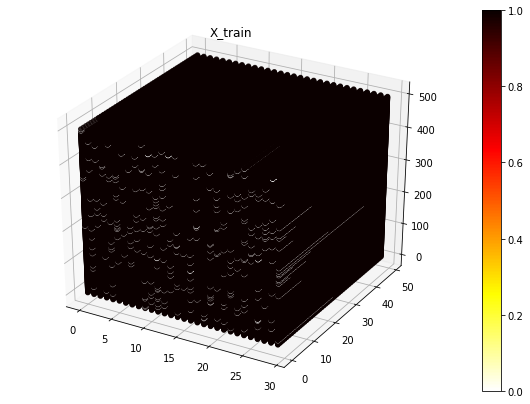

#y_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [1 0 0 ... 0 0 0]


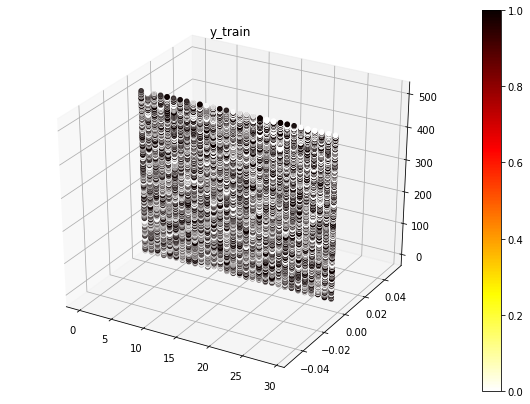

y_train= [[1 0 0 ... 0 1 0]
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
16/16 [==============================] - 1s 3ms/step
#y_train_predicted= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.3036309  0.3916393  0.6442487  ... 0.31670296 0.5255744  0.5157459 ]


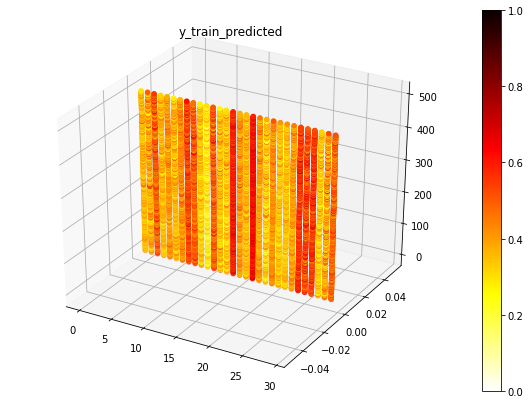

#X_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [ 2  2  4 ... 22  2  2]


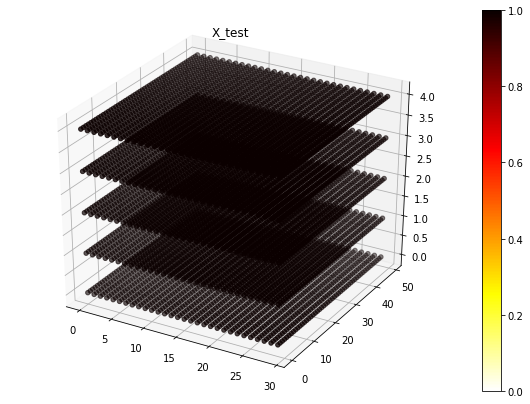

#y_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3

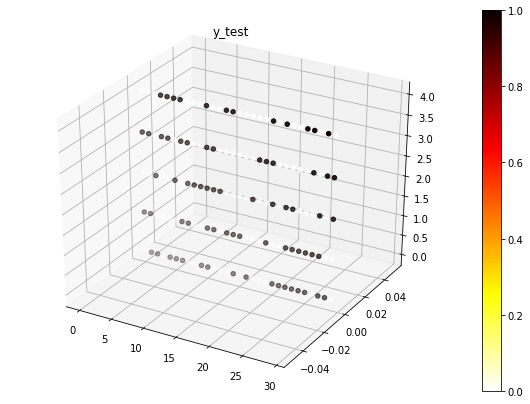

1/1 [==============================] - 0s 20ms/step
#y_test_predicted= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 

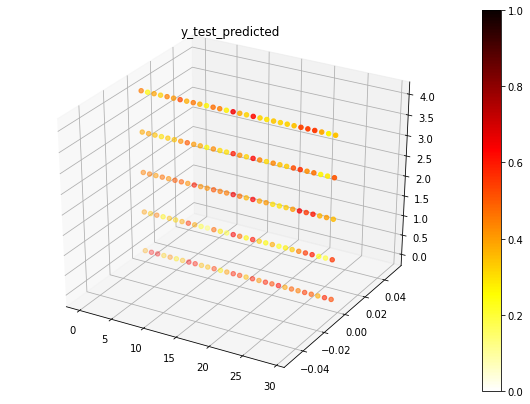

#CX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 0. 0. 0.]


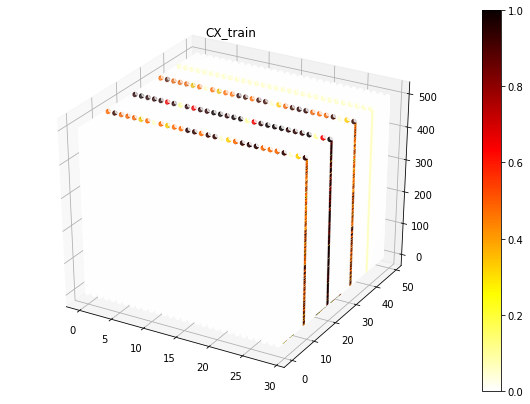

#Cy_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0. 0. 0. ... 1. 1. 1.]


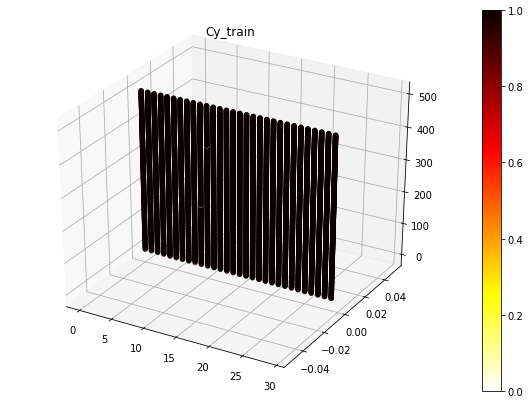

16/16 [==============================] - 1s 4ms/step
#Cy_train_predicted= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.40588322 0.3284685  0.34994608 ... 0.99734503 0.9998964  0.99793196]


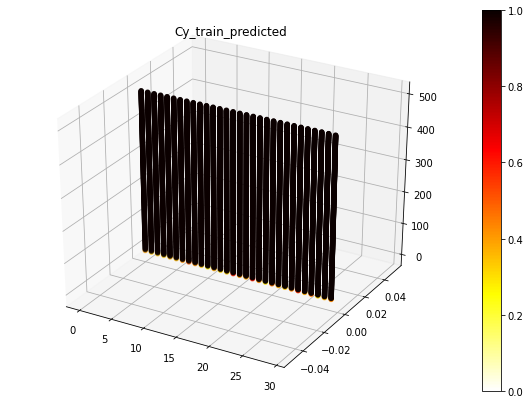

#CX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0. 0. 0. ... 0. 0. 0.]


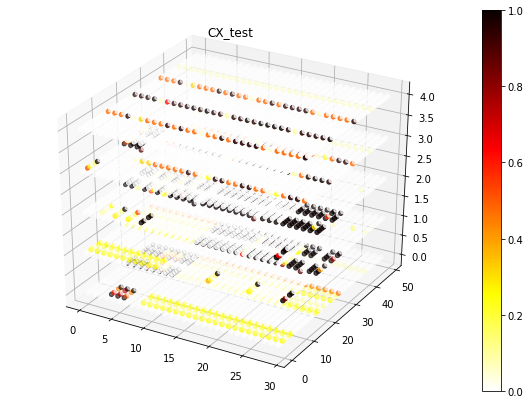

#Cy_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

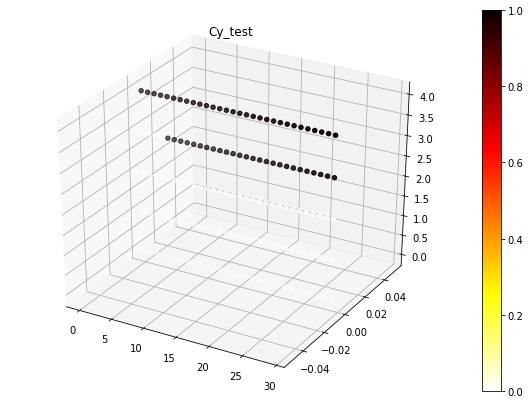

1/1 [==============================] - 0s 16ms/step
#Cy_test_predicted= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2

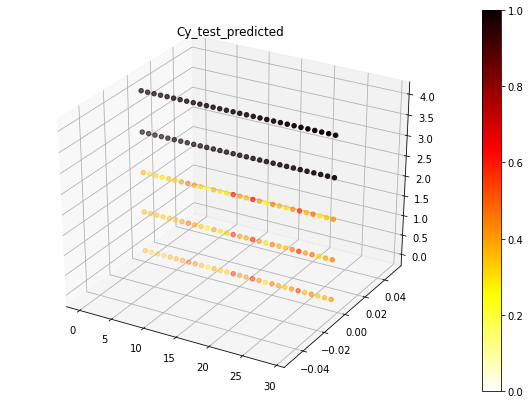

#LX_train= (500, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [  0   0   0 ... 499 499 499]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.76837158e-05 0.00000000e+00]


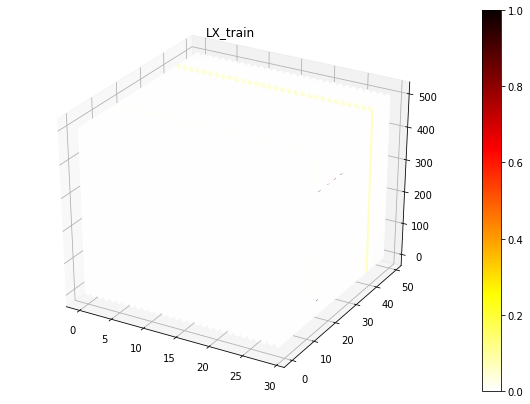

#Ly_train= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [ 0.  0.  0. ... nan nan nan]


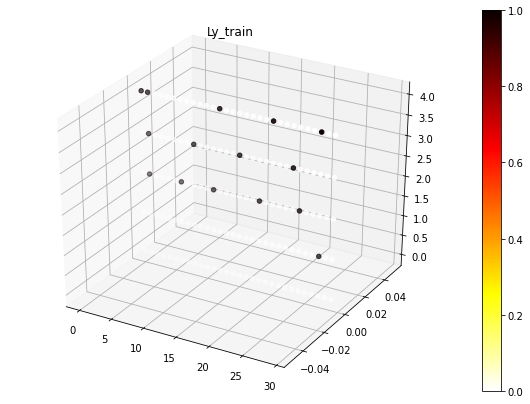

16/16 [==============================] - 0s 5ms/step
#Ly_train_predicted= (500, 30)
x= [ 0  1  2 ... 27 28 29]
y= [0 0 0 ... 0 0 0]
z= [  0   0   0 ... 499 499 499]
c= [0.99895334 0.9966258  0.999209   ... 0.9973641  0.9998399  0.9974598 ]


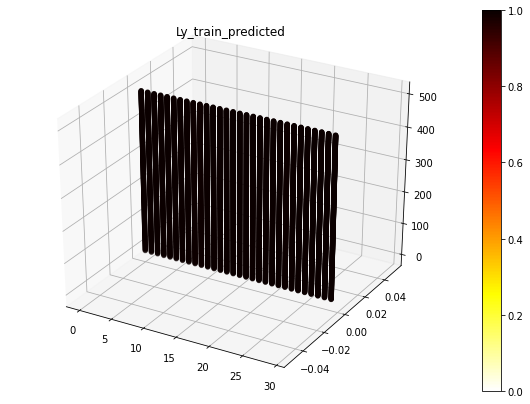

#LX_test= (5, 30, 50)
x= [ 0  0  0 ... 29 29 29]
y= [ 0  1  2 ... 47 48 49]
z= [0 0 0 ... 4 4 4]
c= [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.95910645e-05 0.00000000e+00]


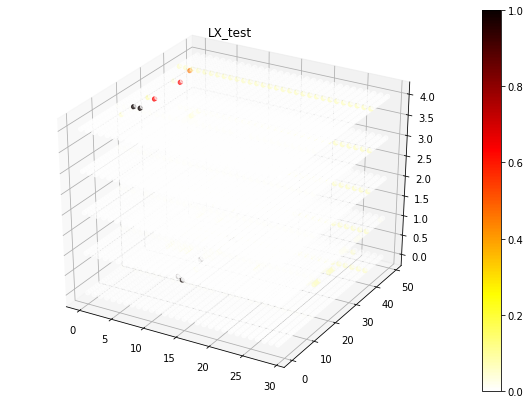

#Ly_test= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 

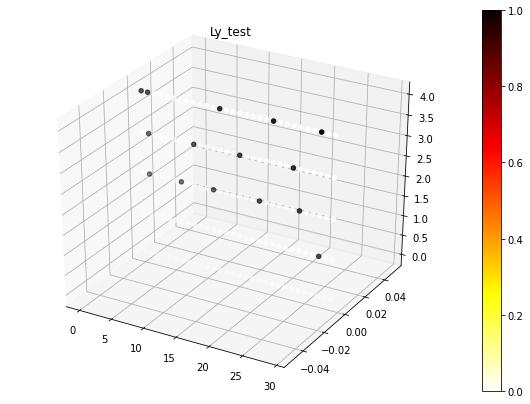

1/1 [==============================] - 0s 18ms/step
#Ly_test_predicted= (5, 30)
x= [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5  6  7  8  9 10 11
 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29  0  1  2  3  4  5
  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
y= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
z= [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2

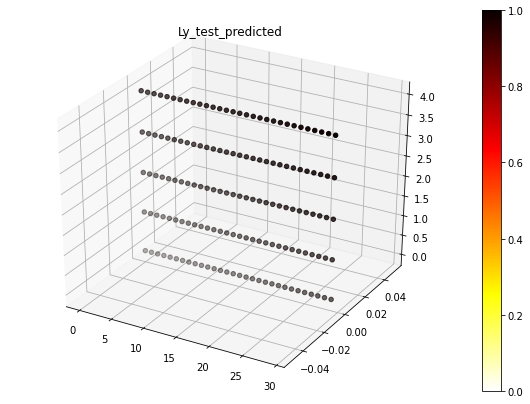

In [ ]:
infer(model8)